목차
* 분석 준비
  * [사용한 모듈](#사용한-모듈)
  * [데이터 확인](#데이터-확인)
* [1. 데이터 전처리 및 랜덤샘플](#데이터-전처리-및-랜덤샘플)
  * [랜덤샘플](#랜덤샘플)
  * [전처리](#전처리)
    * [train, test 데이터 모두에게 적용](#train,-test-데이터-모두에게-적용)
      * [고객 개인 데이터](#고객-개인-데이터(1))
        * [성별, 나이 데이터](#성별,-나이-데이터)
        * [직종 데이터](#직종-데이터)
        * [FP(보험설계사) 데이터](#FP(보험설계사)-데이터)
        * [기간 데이터](#기간-데이터)
        * [보험료 데이터](#보험료-데이터)
        * [소득 추정금액 데이터](#소득-추정금액-데이터)
        * [신용등급 데이터](#신용등급-데이터)
        * [유의 병원 여부 데이터](#유의-병원-여부-데이터)
        * [기타 Y/N 데이터](#기타-Y.N-데이터)
      * [개별 사건 데이터](#개별-사건-데이터(1))
        * [텍스트 데이터](#텍스트-데이터)
    * [분리](#분리)
    * [train 데이터에 적용](#train-데이터에-적용)
      * [고려하지 않을 변수 확인](#고려하지-않을-변수-확인)
        * [고객 개인 데이터 확인](#고객-개인-데이터(2))
        * [개별 사건 데이터 확인](#개별-사건-데이터(2))
      * [고객 개인 데이터](#고객-개인-데이터(3))
        * [TOTALPREM](#TOTALPREM)
        * [MAX_PRM](#MAX_PRM)
        * [CUST_INCM](#CUST_INCM)
        * [RCBASE_HSHD_INCM](#RCBASE_HSHD_INCM)
        * [DMND_AMT](#DMND_AMT)
        * [상관계수 다시 확인](#상관계수-다시-확인)
      * [개별 사건 데이터](#개별-사건-데이터(3))
        * [텍스트 데이터](#텍스트-데이터)
* [2. 학습 및 평가](#학습-및-평가)
  * [학습](#학습)
    * [데이터 정렬](#데이터-정렬)
    * [모델 준비](#모델-준비)
    * [모델 학습](#모델-학습)
  * [평가](평가)

In [1]:
RANDOM_STATE = 53

###### 사용한 모듈

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

#%pip install konlpy
# import konlpy
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# 학습, 평가 데이터 준비
import statsmodels.api as sm # 유의확률
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif # VIF
from sklearn.model_selection import train_test_split
#%pip install imblearn
from imblearn.over_sampling import SMOTE

# 사용한 딥러닝 모델
# from sklearn.neural_network import MLPClassifier
from tensorflow import __version__ as tf_ver
print(f"tensorflow version: {tf_ver}")
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

# 평가
from sklearn.metrics import classification_report, confusion_matrix, f1_score

tensorflow version: 1.15.0


###### 데이터 확인

In [3]:
try:
    temp_xls = pd.ExcelFile("./data/데이터 테이블 및 변수 정의서.xlsx")
    cust_details = pd.read_excel(temp_xls, "CUST_DATA")
    claim_details = pd.read_excel(temp_xls, "CLAIM_DATA")
except FileNotFoundError:
    print("교수님 제 코드는 폴더에 데이터 테이블 및 변수 정의서가 있어야 합니다.")

def mycolfix(str_):
    str_ = str_.strip()
    if str_[-1] not in ('1', '2'):
        return str_
    else:
        return str_[:-1] + '_' + str_[-1]  

cust_details = cust_details.drop(["No", "변수타입", "비고"], axis=1)
cust_details["변수영문명"] = cust_details["변수영문명"].apply(mycolfix)
cust_details["변수명"] = cust_details["변수명"].apply(lambda str_: str_.strip())
cust_details["변수 설명"] = cust_details["변수 설명"].apply(lambda str_: str_.strip())
claim_details = claim_details.drop(["No", "변수타입", "비고"], axis=1)
claim_details["변수영문명"] = claim_details["변수영문명"].apply(lambda str_: str_.strip())
claim_details["변수명"] = claim_details["변수명"].apply(lambda str_: str_.strip())
claim_details["변수 설명"] = claim_details["변수 설명"].apply(lambda str_: str_.strip())

del mycolfix

In [4]:
# 보험회사의 CUSTOMER 데이터
cust_data = pd.read_csv("./data/CUST_DATA.csv", encoding="utf-16")

# DIVIDED_SET열이 1인 데이터들만 학습과 테스트에 사용
print(f"전체 데이터 수: {len(cust_data)}")
print(f"학습/평가에 포함할 데이터 수: {len(cust_data) - (cust_data.DIVIDED_SET != 1).sum()}")
cust_data = cust_data[cust_data.DIVIDED_SET == 1].drop("DIVIDED_SET", axis=1)
cust_data.head()

전체 데이터 수: 22400
학습/평가에 포함할 데이터 수: 20607


,CUST_ID,SIU_CUST_YN,SEX,AGE,RESI_COST,RESI_TYPE_CODE,FP_CAREER,CUST_RGST,CTPR,OCCP_GRP_1,...,WEDD_YN,MATE_OCCP_GRP_1,MATE_OCCP_GRP_2,CHLD_CNT,LTBN_CHLD_AGE,MAX_PAYM_YM,MAX_PRM,CUST_INCM,RCBASE_HSHD_INCM,JPBASE_HSHD_INCM
0,1,N,2,47,21111,20.0,N,199910.0,충북,3.사무직,...,Y,3.사무직,2차산업 종사자,2.0,13.0,200811.0,319718.0,4879.0,10094,11337.0
1,2,N,1,53,40000,20.0,N,199910.0,서울,3.사무직,...,Y,1.주부,주부,2.0,17.0,200012.0,341341.0,6509.0,9143,6509.0
2,3,N,1,60,0,NaN,N,199910.0,서울,5.서비스,...,N,NaN,NaN,0.0,0.0,200305.0,131300.0,4180.0,0,4180.0
3,4,N,2,64,12861,40.0,Y,199910.0,경기,2.자영업,...,N,NaN,NaN,0.0,0.0,201009.0,1493184.0,NaN,4270,5914.0
4,5,N,2,54,0,NaN,Y,199910.0,광주,2.자영업,...,Y,3.사무직,고위 공무원,3.0,19.0,200807.0,166760.0,3894.0,0,8885.0


In [5]:
temp = cust_data.dtypes
for col in cust_data.columns:
    if cust_data[col].nunique() <= 50:
        print(f"{col}:\t({temp[col]})"
              + f" {cust_details[cust_details['변수영문명'] == col]['변수명'].values[0]}"
              + f" - {cust_details[cust_details['변수영문명'] == col]['변수 설명'].values[0]}\n\n"
              + f"\t{cust_data[col].unique()}\n"
              + f"\t\t- {cust_data[col].nunique()}가지 값"
              + f" ({len(cust_data)}개 행 중 결측치 {cust_data[col].isna().sum()}개 행)\n\n")
    else:
        print(f"{col}:\t({temp[col]})"
              + f" {cust_details[cust_details['변수영문명'] == col]['변수명'].values[0]}"
              + f" - {cust_details[cust_details['변수영문명'] == col]['변수 설명'].values[0]}\n\n"
              + f"\t[{cust_data[col].value_counts().idxmax()}"
              + " ... "
              + f"{cust_data[col].value_counts().idxmin()}]\n"
              + f"\t\t- {cust_data[col].nunique()}가지 값"
              + f" ({len(cust_data)}개 행 중 결측치 {cust_data[col].isna().sum()}개 행)\n\n")
del temp

CUST_ID:	(int64) 고객ID - 고객을 구분하는 고유번호

	[2047 ... 2047]
		- 20607가지 값 (20607개 행 중 결측치 0개 행)


SIU_CUST_YN:	(object) 보험사기자여부 - Y의 경우 '보험사기자' / N의 경우 '일반고객' /평가용 Set에는 미부여

	['N' 'Y']
		- 2가지 값 (20607개 행 중 결측치 0개 행)


SEX:	(int64) 성별 - 성별 1은 '남성' 2는 '여성'

	[2 1]
		- 2가지 값 (20607개 행 중 결측치 0개 행)


AGE:	(int64) 연령 - 고객연령

	[56 ... 86]
		- 88가지 값 (20607개 행 중 결측치 0개 행)


RESI_COST:	(int64) 주택가격 - 고객의 거주지 주택가격 추정값 (단위 : 만원) (0 : 추정불가)

	[0 ... 15778]
		- 6285가지 값 (20607개 행 중 결측치 0개 행)


RESI_TYPE_CODE:	(float64) 거주TYPE - 고객의 거주지 형태
 - 일반단독주택(11), 다가구단독주택(12), 영업겸용단독주택(13), 아파트(20),연립_다가구주택(30)
   상가등 비거주용건물(40),오피스텔(50),숙박업소의 객실 또는 판자집 등(60),기숙사(70),그외(99)

	[20. nan 40. 99. 30. 50. 12. 11. 13. 60. 70.]
		- 10가지 값 (20607개 행 중 결측치 1146개 행)


FP_CAREER:	(object) FP경력 - (당사 FP로써의) Y : 경력있음 // N : 경력 없음

	['N' 'Y']
		- 2가지 값 (20607개 행 중 결측치 0개 행)


CUST_RGST:	(float64) 고객등록년월 - 최초 당사의 고객으로써의 등록연월

	[200306.0 ... 198603.0]
		- 363가지 값 (20607개 행 중 결측치 419개 행)


CTPR:	(object) 시도구분 - 고객의 거주 시/도

	['충

In [6]:
# 고객들 CLAIM한 보험금 지급 속성 데이터
claim_data = pd.read_csv("./data/CLAIM_DATA.csv", encoding="utf-16")

print(f"전체 데이터 수: {len(claim_data)}")
claim_data.head()

전체 데이터 수: 119020


,CUST_ID,POLY_NO,ACCI_OCCP_GRP1,ACCI_OCCP_GRP2,CHANG_FP_YN,CNTT_RECP_SQNO,RECP_DATE,ORIG_RESN_DATE,RESN_DATE,CRNT_PROG_DVSN,...,PMMI_DLNG_YN,SELF_CHAM,NON_PAY,TAMT_SFCA,PATT_CHRG_TOTA,DSCT_AMT,COUNT_TRMT_ITEM,DCAF_CMPS_XCPA,NON_PAY_RATIO,HEED_HOSP_YN
0,5936,1365,8.기타,학생,Y,2006011200001,20060112,20060109,20060109,11,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N
1,5936,6151,8.기타,학생,Y,2006011200002,20060112,20060109,20060109,11,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N
2,5936,10364,8.기타,학생,Y,2006011200003,20060112,20060109,20060109,11,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N
3,1043,1247,1.주부,주부,N,2006011200004,20060112,20060105,20060105,23,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N
4,8545,11236,1.주부,주부,Y,2006011200005,20060112,20060110,20060110,11,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N


In [7]:
temp = claim_data.dtypes
for col in claim_data.columns:
    try:
        if claim_data[col].nunique() <= 50:
            print(f"{col}:\t({temp[col]})"
                  + f" {claim_details[claim_details['변수영문명'] == col]['변수명'].values[0]}"
                  + f" - {claim_details[claim_details['변수영문명'] == col]['변수 설명'].values[0]}\n\n"
                  + f"\t{claim_data[col].unique()}\n"
                  + f"\t\t- {claim_data[col].nunique()}가지 값"
                  + f" ({len(claim_data)}개 행 중 결측치 {claim_data[col].isna().sum()}개 행)\n\n")
        else:
            print(f"{col}:\t({temp[col]})"
                  + f" {claim_details[claim_details['변수영문명'] == col]['변수명'].values[0]}"
                  + f" - {claim_details[claim_details['변수영문명'] == col]['변수 설명'].values[0]}\n\n"
                  + f"\t[{claim_data[col].value_counts().idxmax()}"
                  + " ... "
                  + f"{claim_data[col].value_counts().idxmin()}]\n"
                  + f"\t\t- {claim_data[col].nunique()}가지 값"
                  + f" ({len(claim_data)}개 행 중 결측치 {claim_data[col].isna().sum()}개 행)\n\n")
    except IndexError:
        print(f"{col}:\t({temp[col]})"
                  + " * 데이터 테이블 및 변수 정의서에 없는 컬럼\n\n"+ f"\t[{claim_data[col].value_counts().idxmax()}"
                  + " ... "
                  + f"{claim_data[col].value_counts().idxmin()}]\n"
                  + f"\t\t- {claim_data[col].nunique()}가지 값"
                  + f" ({len(claim_data)}개 행 중 결측치 {claim_data[col].isna().sum()}개 행)\n\n")
        
del temp

CUST_ID:	(int64) 고객ID - 고객을 구분하는 고유번호

	[15109 ... 4193]
		- 22400가지 값 (119020개 행 중 결측치 0개 행)


POLY_NO:	(int64) 증권번호 - 청약서번호이면서 동시에 계약성립후에는 증권번호로 사용

	[15009 ... 9333]
		- 28031가지 값 (119020개 행 중 결측치 0개 행)


ACCI_OCCP_GRP1:	(object) 직업그룹코드1 - 총 8개직업군으로 분류한 코드(사고 당시)

	['8.기타' '1.주부' '2.자영업' '5.서비스' '3.사무직' '6.제조업' '4.전문직' '7.1차산업' nan]
		- 8가지 값 (119020개 행 중 결측치 1417개 행)


ACCI_OCCP_GRP2:	(object) 직업그룹코드2 - 총 25개직업군으로 분류한 코드(사고 당시)

	['학생' '주부' '자영업' '2차산업 종사자' '3차산업 종사자' '사무직' '전문직' '예체능계 종사자' '의료직 종사자'
 '운전직' '기타' '1차산업 종사자' '기업/단체 임원' '교사' '단순 사무직' '공무원' '고위 공무원' '교육관련직' nan
 '종교인/역술인' '단순 노무직' '고소득의료직' '대학교수/강사' '학자/연구직' '고소득 전문직' '법무직 종사자']
		- 25가지 값 (119020개 행 중 결측치 1417개 행)


CHANG_FP_YN:	(object) FP 변경 여부 - 모집 FP와 청구 당시 수금 FP 와의 동일 여부

	['Y' 'N']
		- 2가지 값 (119020개 행 중 결측치 0개 행)


CNTT_RECP_SQNO:	(int64) 계약별접수일련번호 - 사고접수에 대해 해당 계약건별로 부여하는 번호

	[2010082400021 ... 2010082400021]
		- 119020가지 값 (119020개 행 중 결측치 0개 행)


RECP_DATE:	(int64) 사고접수일자 - 사고가 접수된 일자

	[20160519 ... 200601

In [8]:
del cust_details, claim_details

# 데이터 전처리 및 랜덤샘플

## 랜덤샘플

In [9]:
# 'Y', 'N' -> 1, 0 변환
my_yn_to_10 = lambda chr_: 1 if chr_ == 'Y' else 0

cust_data["SIU_CUST_BOOL"] = cust_data.SIU_CUST_YN.apply(my_yn_to_10).astype("int8")
cust_data = cust_data.drop(["SIU_CUST_YN"], axis=1)

data_index = pd.concat([cust_data["CUST_ID"], cust_data["SIU_CUST_BOOL"]], axis=1)

train_index, test_index = \
    train_test_split(data_index, test_size=0.3, random_state=RANDOM_STATE, stratify=data_index.SIU_CUST_BOOL)

# class의 비율 비슷하게 split 됐는지 확인 
print("train data 내 보험사기자 비율:"
      +f'\t{len(train_index[train_index["SIU_CUST_BOOL"] == 1]) / len(train_index)}')
print("test data 내 보험사기자 비율:"
      +f'\t{len(test_index[test_index["SIU_CUST_BOOL"] == 1]) / len(test_index)}')

del data_index

train data 내 보험사기자 비율:	0.08763172490293955
test data 내 보험사기자 비율:	0.08765971211386059


## 전처리
* 모든 데이터를 0~1 사이로 만들기로

### train, test 데이터 모두에게 적용
 * 단, 전체 분포 확인 안하는 단계에서

#### 고객 개인 데이터(1)

###### 성별, 나이 데이터

In [10]:
cust_data["SEX"] = cust_data.SEX\
    .apply(lambda num_: 0 if num_ == 2 else num_).astype("int8")
cust_data["AGE_scaled"] = cust_data.AGE\
    .apply(lambda num_: num_ / 100).astype("float16") # 0~1로 정규화

cust_data = cust_data.drop(["AGE"], axis=1)

###### 직종 데이터

In [11]:
temp_job = cust_data["OCCP_GRP_1"].fillna("9.결측치") + ' ' + cust_data["OCCP_GRP_2"].fillna("결측치")
job_list = list(temp_job.sort_values().unique())
del temp_job
print(job_list, len(job_list))

['1.주부 주부', '2.자영업 3차산업 종사자', '2.자영업 자영업', '3.사무직 1차산업 종사자', '3.사무직 2차산업 종사자', '3.사무직 3차산업 종사자', '3.사무직 고위 공무원', '3.사무직 공무원', '3.사무직 교육관련직', '3.사무직 기업/단체 임원', '3.사무직 단순 노무직', '3.사무직 단순 사무직', '3.사무직 사무직', '3.사무직 학생', '4.전문직 1차산업 종사자', '4.전문직 2차산업 종사자', '4.전문직 3차산업 종사자', '4.전문직 고소득 전문직', '4.전문직 고소득의료직', '4.전문직 공무원', '4.전문직 교사', '4.전문직 교육관련직', '4.전문직 대학교수/강사', '4.전문직 법무직 종사자', '4.전문직 사무직', '4.전문직 예체능계 종사자', '4.전문직 의료직 종사자', '4.전문직 전문직', '4.전문직 종교인/역술인', '4.전문직 학자/연구직', '5.서비스 1차산업 종사자', '5.서비스 2차산업 종사자', '5.서비스 3차산업 종사자', '5.서비스 교육관련직', '5.서비스 사무직', '5.서비스 예체능계 종사자', '5.서비스 운전직', '5.서비스 의료직 종사자', '5.서비스 자영업', '5.서비스 전문직', '5.서비스 종교인/역술인', '6.제조업 1차산업 종사자', '6.제조업 2차산업 종사자', '6.제조업 3차산업 종사자', '6.제조업 운전직', '6.제조업 전문직', '7.1차산업 1차산업 종사자', '8.기타 1차산업 종사자', '8.기타 2차산업 종사자', '8.기타 3차산업 종사자', '8.기타 공무원', '8.기타 기타', '8.기타 단순 노무직', '8.기타 운전직', '8.기타 자영업', '8.기타 주부', '8.기타 학생', '9.결측치 결측치'] 58


In [12]:
my_job_dict = {
    # 학생
    '3.사무직 학생': 1, '8.기타 학생': 1, 
    # 주부
    '1.주부 주부': 2, '8.기타 주부': 2, 
    # 자영업
    '2.자영업 자영업': 3, '2.자영업 3차산업 종사자': 3, '5.서비스 자영업': 3, '8.기타 자영업': 3, 
    # 노무직 및 운전직
    '3.사무직 단순 노무직': 4, '8.기타 단순 노무직': 4, 
    '5.서비스 운전직': 4, '6.제조업 운전직': 4, '8.기타 운전직': 4,
    # 노무직 및 1, 2차 산업 종사자
    '4.전문직 종교인/역술인': 5, '5.서비스 종교인/역술인': 5, 
    # 전문직
    '4.전문직 1차산업 종사자': 6, '4.전문직 2차산업 종사자': 6, '4.전문직 3차산업 종사자': 6, 
    '4.전문직 교사': 6, '4.전문직 교육관련직': 6, '4.전문직 대학교수/강사': 6, 
    '4.전문직 사무직': 6, '4.전문직 예체능계 종사자': 6, '4.전문직 전문직': 6, 
    '4.전문직 학자/연구직': 6, 
    # 사무직
    '3.사무직 1차산업 종사자': 7, '3.사무직 2차산업 종사자': 7, '3.사무직 3차산업 종사자': 7, 
    '3.사무직 교육관련직': 7, '3.사무직 단순 사무직': 7, '3.사무직 사무직': 7, 
    # 서비스
    '5.서비스 1차산업 종사자': 8, '5.서비스 2차산업 종사자': 8, '5.서비스 3차산업 종사자': 8, 
    '5.서비스 교육관련직': 8, '5.서비스 사무직': 8, '5.서비스 예체능계 종사자': 8, 
    '5.서비스 의료직 종사자': 8, '5.서비스 전문직': 8, 
    # 제조업
    '6.제조업 1차산업 종사자': 9, '6.제조업 2차산업 종사자': 9, '6.제조업 3차산업 종사자': 9, 
    '6.제조업 전문직': 9, 
    # 1차 산업 종사자
    '7.1차산업 1차산업 종사자': 10, 
    # 공무직
    '3.사무직 공무원': 11, '4.전문직 공무원': 11, '8.기타 공무원': 11, 
    # 고소득 특수직 - 법, 의료
    '4.전문직 법무직 종사자': 12, '4.전문직 의료직 종사자': 12, 
    '4.전문직 고소득 전문직': 12, '4.전문직 고소득의료직': 12, 
    # 고위직
    '3.사무직 고위 공무원': 13, '3.사무직 기업/단체 임원': 13, 
    # 기타 (버릴 예정)
    '8.기타 1차산업 종사자': 0, '8.기타 2차산업 종사자': 0, '8.기타 3차산업 종사자': 0, 
    '8.기타 기타': 0, '9.결측치 결측치': 0
}

MY_JOB_LEN = 14

In [13]:
temp_job = pd.concat([
    cust_data["CUST_ID"],
    cust_data["OCCP_GRP_1"], cust_data["OCCP_GRP_2"],
    cust_data["MATE_OCCP_GRP_1"], cust_data["MATE_OCCP_GRP_2"]
], axis=1)

In [14]:
# 고객 본인의 직업
temp_job["OCCP_CUST"] = \
    temp_job["OCCP_GRP_1"].fillna("9.결측치") + ' ' + temp_job["OCCP_GRP_2"].fillna("결측치")
temp_job["OCCP_CUST_NUM"] = temp_job["OCCP_CUST"].apply(lambda str_: my_job_dict[str_])

# 고객 배우자의 직업
temp_job["OCCP_MATE"] = \
    temp_job["MATE_OCCP_GRP_1"].fillna("9.결측치") + ' ' + temp_job["MATE_OCCP_GRP_2"].fillna("결측치")
temp_job["OCCP_MATE_NUM"] = temp_job["OCCP_MATE"].apply(lambda str_: my_job_dict[str_])

temp_job = temp_job.drop([
    "OCCP_GRP_1", "OCCP_GRP_2",
    "MATE_OCCP_GRP_1", "MATE_OCCP_GRP_2",
    "OCCP_CUST", "OCCP_MATE"    
], axis=1)

In [15]:
temp_job2 = pd.concat([
    claim_data["CUST_ID"],
    claim_data["ACCI_OCCP_GRP1"], claim_data["ACCI_OCCP_GRP2"]
], axis=1)

temp_job2 = temp_job2.drop_duplicates()

In [16]:
# 고객 사고 당시의 직업
temp_job2["OCCP_ACCI"] = \
    temp_job2["ACCI_OCCP_GRP1"].fillna("9.결측치") + ' ' + temp_job2["ACCI_OCCP_GRP2"].fillna("결측치")
temp_job2["OCCP_ACCI_NUM"] = temp_job2["OCCP_ACCI"].apply(lambda str_: my_job_dict[str_])

temp_job2 = temp_job2.drop(["OCCP_ACCI", "ACCI_OCCP_GRP1", "ACCI_OCCP_GRP2"], axis=1)

In [17]:
all_jobs = dict()

for _, row in temp_job.iterrows():
    if row.CUST_ID not in all_jobs:
        all_jobs[row.CUST_ID] = set()
        
    if row.OCCP_CUST_NUM != 0:
        all_jobs[row.CUST_ID].add(row.OCCP_CUST_NUM) # 고객 본인의 직업
    if row.OCCP_MATE_NUM != 0:
        all_jobs[row.CUST_ID].add(row.OCCP_MATE_NUM) # 고객 배우자의 직업

for _, row in temp_job2.iterrows():
    if row.CUST_ID not in all_jobs:
        all_jobs[row.CUST_ID] = set()
    
    if row.OCCP_ACCI_NUM != 0:
        all_jobs[row.CUST_ID].add(row.OCCP_ACCI_NUM) # 고객 사고 당시의 직업

del temp_job, temp_job2

In [18]:
def from_dict_to_multi_rows(id_, num_):
    return 1 if num_ in all_jobs[id_] else 0

for i in range(1, MY_JOB_LEN):
    new_col = "OCCP_RELEVENT_" + str(i)
    cust_data[new_col] = cust_data["CUST_ID"].apply(from_dict_to_multi_rows, num_=i).astype("int8")

cust_data = cust_data.drop([
    "OCCP_GRP_1", "OCCP_GRP_2", 
    "MATE_OCCP_GRP_1", "MATE_OCCP_GRP_2"
], axis=1)
del from_dict_to_multi_rows, all_jobs

###### FP(보험설계사) 데이터

In [19]:
# 'Y', 'N' -> 1, 0 변환
my_yn_to_10 = lambda chr_: 1 if chr_ == 'Y' else 0

cust_data["FP_CAREER_BOOL"] = cust_data.FP_CAREER.apply(my_yn_to_10).astype("int8")
claim_data["CHANGE_FP_BOOL"] = claim_data.CHANG_FP_YN.apply(my_yn_to_10).astype("int8")

cust_data = cust_data.drop(["FP_CAREER"], axis=1)
claim_data = claim_data.drop(["CHANG_FP_YN"], axis=1)

In [20]:
# 보험료 청구 사례 중 FP 변경이 한번이라도 있었는가
temp_fp = claim_data[claim_data["CHANGE_FP_BOOL"] == 1]
temp_fp = pd.concat([
    temp_fp["CUST_ID"],
    temp_fp["CHANGE_FP_BOOL"]
], axis=1).drop_duplicates()
cust_data = pd.merge(cust_data, temp_fp, how="left", on="CUST_ID")
cust_data["CHANGE_FP_BOOL"] = cust_data["CHANGE_FP_BOOL"].fillna(0).astype("int8")
del temp_fp

###### 기간 데이터

In [21]:
print(cust_data.CUST_RGST.max(), cust_data.MAX_PAYM_YM.max())
print(cust_data.CUST_RGST.min(), cust_data.MAX_PAYM_YM.min())

201602.0 207110.0
101.0 199801.0


In [22]:
cust_data["CUST_RGST_Y"] = cust_data["CUST_RGST"] // 100
cust_data["MAX_PAYM_Y"] = cust_data["MAX_PAYM_YM"] // 100

print(cust_data.CUST_RGST_Y.max(), cust_data.MAX_PAYM_Y.max())
print(cust_data.CUST_RGST_Y.min(), cust_data.MAX_PAYM_Y.min())

2016.0 2071.0
1.0 1998.0


(1950, 2016)

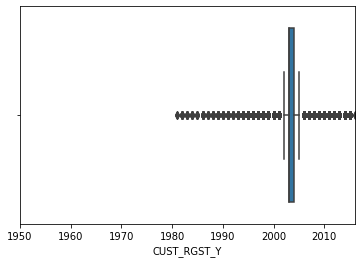

In [23]:
sns.boxplot(x="CUST_RGST_Y", data=cust_data)
plt.xlim(1950, 2016) # 2016년 빅콘 문제이기 때문

In [24]:
# 불량 기간 데이터를 임시로 0으로 지정
cust_data.loc[cust_data["CUST_RGST"] < 196000, "CUST_RGST"] = np.nan
cust_data.loc[cust_data["CUST_RGST"] > 201612, "CUST_RGST"] = np.nan
cust_data.loc[cust_data["MAX_PAYM_YM"] < 196000, "MAX_PAYM_YM"] = np.nan
cust_data.loc[cust_data["MAX_PAYM_YM"] > 201612, "MAX_PAYM_YM"] = np.nan
cust_data.loc[cust_data["CUST_RGST"].isna(), "CUST_RGST"] = 0
cust_data.loc[cust_data["MAX_PAYM_YM"].isna(), "MAX_PAYM_YM"] = 0

cust_data["CUST_RGST_Y"] = cust_data["CUST_RGST"] // 100
cust_data["CUST_RGST_M"] = cust_data["CUST_RGST"] % 100
cust_data["MAX_PAYM_Y"] = cust_data["MAX_PAYM_YM"] // 100
cust_data["MAX_PAYM_M"] = cust_data["MAX_PAYM_YM"] % 100

cust_data.loc[cust_data["CUST_RGST_M"] < 1, "CUST_RGST_M"] = 0
cust_data.loc[cust_data["CUST_RGST_M"] > 12, "CUST_RGST_M"] = 0
cust_data.loc[cust_data["MAX_PAYM_M"] < 1, "MAX_PAYM_M"] = 0
cust_data.loc[cust_data["MAX_PAYM_M"] > 12, "MAX_PAYM_M"] = 0

cust_data["CUST_RGST_Y"] = cust_data["CUST_RGST_Y"].apply(int).apply(str)
cust_data["CUST_RGST_M"] = cust_data["CUST_RGST_M"].apply(int).apply(str)
cust_data["MAX_PAYM_Y"] = cust_data["MAX_PAYM_Y"].apply(int).apply(str)
cust_data["MAX_PAYM_M"] = cust_data["MAX_PAYM_M"].apply(int).apply(str)

cust_data = cust_data.drop(["CUST_RGST", "MAX_PAYM_YM"], axis=1)

In [25]:
def my_twomonths_sub(str_):
    after, before = str_.split('|')
    afterY, afterM = after.split('-')
    beforeY, beforeM = before.split('-')
    afterY, afterM = int(afterY), int(afterM)
    beforeY, beforeM = int(beforeY), int(beforeM)
    if 0 in (afterY, afterM, beforeY, beforeM):
        return -1
    elif beforeY * 100 + beforeM > afterY * 100 + afterM:
        return -1
    
    years = afterY - beforeY - 1
    if years == -1:
        return afterM - beforeM
    else:
        return (years * 12) + afterM - (beforeM - 1)

cust_data["MAX_RGST_SUB_M"] = \
    cust_data["MAX_PAYM_Y"] + '-' + cust_data["MAX_PAYM_M"] \
    + '|' + cust_data["CUST_RGST_Y"] + '-' + cust_data["CUST_RGST_M"]

cust_data["MAX_RGST_SUB_M"] = cust_data["MAX_RGST_SUB_M"].apply(my_twomonths_sub)

del my_twomonths_sub

In [26]:
cust_data["MAX_RGST_SUB_M_scaled"] = \
    cust_data["MAX_RGST_SUB_M"].apply(lambda num_: 0 if num_ < 1 else num_)
cust_data["MAX_RGST_SUB_M_scaled"] = \
    cust_data["MAX_RGST_SUB_M_scaled"] \
    .apply(lambda num_: (np.log(num_+1) / np.log(36)) - 1) # 36개월 = 3년

In [27]:
claim_data["RECP_DATE"] = claim_data["RECP_DATE"].apply(str)
claim_data["ORIG_RESN_DATE"] = claim_data["ORIG_RESN_DATE"].apply(str)
claim_data["RESN_DATE"] = claim_data["RESN_DATE"].apply(str)

claim_data["RECP_DATE"] = claim_data["RECP_DATE"].apply(pd.to_datetime, format="%Y%m%d")
claim_data["ORIG_RESN_DATE"] = claim_data["ORIG_RESN_DATE"].apply(pd.to_datetime, format="%Y%m%d")
claim_data["RESN_DATE"] = claim_data["RESN_DATE"].apply(pd.to_datetime, format="%Y%m%d")

In [28]:
temp_date = claim_data[[
    "CNTT_RECP_SQNO", "RECP_DATE", "ORIG_RESN_DATE", "RESN_DATE", "VLID_HOSP_OTDA"
]]

temp_date["RECP_RESN_SUB_D"] = temp_date["RECP_DATE"] - temp_date["ORIG_RESN_DATE"]

def my_total_days(timedelta_):
    return datetime.timedelta.total_seconds(timedelta_) / (60 * 60 * 24)

# 시고접수일자 - 해당 사고의 최초 사유발생일자
temp_date["RECP_RESN_SUB_D"] = temp_date.RECP_RESN_SUB_D.apply(my_total_days)

# 사고발생~사고접수 기간 - 유효입원/통원일수
temp_date["RECP_HOSP_SUB_D"] = temp_date["RECP_RESN_SUB_D"] - temp_date["VLID_HOSP_OTDA"]

temp_date = temp_date.drop(["RECP_DATE", "ORIG_RESN_DATE", "RESN_DATE", "VLID_HOSP_OTDA"], axis=1)

C:\Programming\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Programming\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Programming\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [29]:
claim_data = pd.merge(claim_data, temp_date, how="left", on="CNTT_RECP_SQNO")
del temp_date

In [30]:
temp_date = claim_data.groupby("CUST_ID")[["RECP_RESN_SUB_D", "RECP_HOSP_SUB_D"]].mean()
temp_date = temp_date.reset_index()
cust_data = pd.merge(cust_data, temp_date, how="left", on="CUST_ID")
del temp_date

In [31]:
cust_data["RECP_RESN_SUB_Dmean_scaled"] = \
    cust_data["RECP_RESN_SUB_D"].apply(lambda num_: 0 if num_ < 0 else num_)
cust_data["RECP_RESN_SUB_Dmean_scaled"] = \
    cust_data["RECP_RESN_SUB_Dmean_scaled"] \
    .apply(lambda num_: (np.log(num_+1) / np.log(60)) - 1) # 60일 = 1개월

cust_data["RECP_HOSP_SUB_Dmean_scaled"] = \
    cust_data["RECP_HOSP_SUB_D"].apply(lambda num_: 0 if num_ < 0 else num_)
cust_data["RECP_HOSP_SUB_Dmean_scaled"] = \
    cust_data["RECP_HOSP_SUB_Dmean_scaled"] \
    .apply(lambda num_: (np.log(num_+1) / np.log(60)) - 1) # 60일 = 1개월

###### 보험료 데이터

In [32]:
cust_data.loc[cust_data["TOTALPREM"] < 1, "TOTALPREM"] = np.nan
cust_data.loc[cust_data["MAX_PRM"] < 1, "MAX_PRM"] = np.nan
cust_data.loc[cust_data["TOTALPREM"].isna(), "TOTALPREM"] = 1
cust_data.loc[cust_data["MAX_PRM"].isna(), "MAX_PRM"] = 1

In [33]:
temp_money = claim_data.groupby("CUST_ID")[["DMND_AMT", "PAYM_AMT"]].sum()
temp_money = temp_money.reset_index()
cust_data = pd.merge(cust_data, temp_money, how="left", on="CUST_ID")
del temp_money

###### 소득 추정금액 데이터

In [34]:
# 불량 수치 데이터를 임시로 null, nan 등으로 지정
cust_data.loc[cust_data["CUST_INCM"] == 0., "CUST_INCM"] = np.nan
cust_data.loc[cust_data["RCBASE_HSHD_INCM"] == 0., "RCBASE_HSHD_INCM"] = np.nan
cust_data.loc[cust_data["JPBASE_HSHD_INCM"] == 0., "JPBASE_HSHD_INCM"] = np.nan

cust_data.loc[cust_data["CUST_INCM"].isna(), "CUST_INCM"] = 0
cust_data.loc[cust_data["RCBASE_HSHD_INCM"].isna(), "RCBASE_HSHD_INCM"] = 0
cust_data.loc[cust_data["JPBASE_HSHD_INCM"].isna(), "JPBASE_HSHD_INCM"] = 0

###### 신용등급 데이터

In [35]:
cust_data.loc[cust_data["MINCRDT"].isin((0., 28., 99.)), "MINCRDT"] = np.nan
cust_data.loc[cust_data["MAXCRDT"].isin((0., 28., 99.)), "MAXCRDT"] = np.nan
cust_data.loc[cust_data["MINCRDT"].isna(), "MINCRDT"] = 6 # 미확인의 경우 6등급에 포함
cust_data.loc[cust_data["MAXCRDT"].isna(), "MAXCRDT"] = 6 # 미확인의 경우 6등급에 포함

In [36]:
cust_data["SUBCRDT"] = cust_data["MAXCRDT"] - cust_data["MINCRDT"]
cust_data["AVGCRDT"] = (cust_data["MAXCRDT"] + cust_data["MINCRDT"]) / 2

In [37]:
# 평균 신용등급 데이터, 최대-최소 신용등급 데이터 간 차 모두 0~10을 벗어날 수 없다.
cust_data["MINCRDT_scaled"] = cust_data["MINCRDT"] / 10
cust_data["MAXCRDT_scaled"] = cust_data["MAXCRDT"] / 10
cust_data["SUBCRDT_scaled"] = cust_data["SUBCRDT"].apply(lambda num_: -num_ if num_ < 0 else num_) / 10
cust_data["AVGCRDT_scaled"] = cust_data["AVGCRDT"] / 10

###### 유의 병원 여부 데이터

In [38]:
# 'Y', 'N' -> 1, 0 변환
my_yn_to_10 = lambda chr_: 1 if chr_ == 'Y' else 0

claim_data["HEED_HOSP_BOOL"] = claim_data.HEED_HOSP_YN.apply(my_yn_to_10).astype("int8")

claim_data = claim_data.drop(["HEED_HOSP_YN"], axis=1)

In [39]:
# 유의 병원을 한번이라도 이용했는가
temp_hosp = claim_data[claim_data["HEED_HOSP_BOOL"] == 1]
temp_hosp = pd.concat([
    temp_hosp["CUST_ID"],
    temp_hosp["HEED_HOSP_BOOL"]
], axis=1).drop_duplicates()
cust_data = pd.merge(cust_data, temp_hosp, how="left", on="CUST_ID")
cust_data["HEED_HOSP_BOOL"] = cust_data["HEED_HOSP_BOOL"].fillna(0).astype("int8")
del temp_hosp

###### 기타 Y.N 데이터

In [40]:
# 'Y', 'N' -> 1, 0 변환
my_yn_to_10 = lambda chr_: 1 if chr_ == 'Y' else 0

cust_data["WEDD_BOOL"] = cust_data.WEDD_YN.fillna('N').apply(my_yn_to_10).astype("int8")
claim_data["PMMI_DLNG_BOOL"] = claim_data.PMMI_DLNG_YN.apply(my_yn_to_10).astype("int8")

cust_data = cust_data.drop(["WEDD_YN"], axis=1)
claim_data = claim_data.drop(["PMMI_DLNG_YN"], axis=1)

del my_yn_to_10

#### 개별 사건 데이터(1)

###### 텍스트 데이터

In [41]:
claim_data.loc[:, ["DSAS_NAME", "RESL_NM1"]].head()

,DSAS_NAME,RESL_NM1
0,하악부표재성손상,머리의 얕은(표재성)손상
1,하악부표재성손상,머리의 얕은(표재성)손상
2,하악부표재성손상,머리의 얕은(표재성)손상
3,기타세균성창자감염|손목및손의2도화상|피부염,감염성 및 상세불명 기원의 기타위장염 및 결장염
4,좌측하지정맥류혈관발거술|레이저소작술,다리(하지)의 정맥류


In [42]:
# 랜덤한 줄
my_random_row = claim_data.loc[53, ["DSAS_NAME", "RESL_NM1"]].values
my_random_row

array(['우측요관결석(요관경하쇄석술)', '신장 및 요관의 결석'], dtype=object)

In [43]:
okt=Okt()
kkma=Kkma()
kmrn=Komoran()
han=Hannanum()

In [44]:
print(okt.nouns(my_random_row[0]), okt.nouns(my_random_row[1]))
print(kkma.nouns(my_random_row[0]), kkma.nouns(my_random_row[1]))
print(kmrn.nouns(my_random_row[0]), kmrn.nouns(my_random_row[1]))
print(han.nouns(my_random_row[0]), han.nouns(my_random_row[1]))

['우측', '요관', '결석', '요관', '경하', '쇄', '술'] ['신장', '및', '요관', '결석']
['우측', '우측요관결석', '요관', '결석', '요관경하쇄석술', '경하', '쇄석술'] ['신장', '요관', '결석']
['우측', '요', '관', '결석', '요', '관', '경하', '쇄', '석', '술'] ['신장', '관의', '결석']
['우측요관결석(요관경하쇄석술'] ['신장', '요관', '결석']


In [45]:
# 꼬꼬마의 결과가 마음에 든다
del okt, kmrn, han, my_random_row

In [46]:
claim_doc_data = claim_data.copy()
claim_doc_data = claim_doc_data[[
    "CUST_ID", "CNTT_RECP_SQNO",
    # document화 시킬 데이터
    "ACCI_DVSN", 
    # "DSAS_NAME", "RESL_NM1", # 너무 오래 걸려서 한번 실행 후 별도의 파일로 저장
    "DMND_RESN_CODE", 
    "HEED_HOSP_BOOL", "HOSP_SPEC_DVSN", "ACCI_HOSP_ADDR",
    # 이외 관련 수치 데이터
    "HOUSE_HOSP_DIST" 
]]
claim_doc_data = pd.merge(claim_doc_data, cust_data[["CUST_ID", "CTPR"]], how="left", on="CUST_ID")

In [47]:
# 청구사유코드 상 해지/무효인 데이터 제외
claim_doc_data = claim_doc_data[claim_doc_data["DMND_RESN_CODE"] != 9]

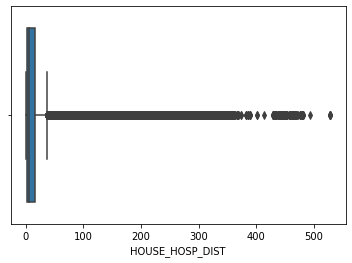

In [48]:
sns.boxplot(x="HOUSE_HOSP_DIST", data=claim_doc_data)

(0, 50)

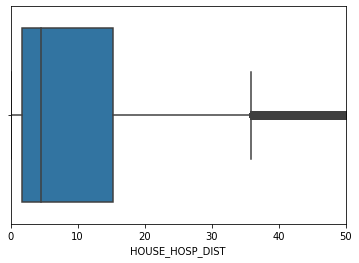

In [49]:
sns.boxplot(x="HOUSE_HOSP_DIST", data=claim_doc_data)
plt.xlim(0, 50)

In [50]:
# # 꼬꼬마 실행시간이 너무 오래 걸려 중복되는 줄은 한번만 계산해야 함
# # unique 한 값 -> 코드로 저장
        
# all_resl = dict()

# temp = list()
# i = 0
# for row in claim_doc_data["RESL_NM1"].unique():
#     if row not in temp:
#         all_resl['B' + str(i)] = row
#         temp.append(row)
#         i += 1

# del temp

In [51]:
# # 꼬꼬마로 명사 추출
# all_resl_result = pd.Series(all_resl)

# # 여기서 12초 정도 소요, DSAS에 비해 정말 얼마 안걸림
# t0 = time.time()
# all_resl_result = all_resl_result.apply(kkma.nouns)
# print(f"Kkma took {datetime.timedelta(seconds=int(round(time.time() - t0)))} seconds to tokenize RESL.")

In [52]:
# all_resl_origin = pd.Series(all_resl)
# del all_resl
# all_resl = pd.merge(all_resl_origin.reset_index(), all_resl_result.reset_index(), how="inner", on="index")
# all_resl = all_resl.drop(["index"], axis=1).set_index("0_x").to_dict()
# all_resl = all_resl["0_y"]

# del all_resl_origin, all_resl_result

In [53]:
# "DSAS_NAME"는 너무 길어서 unique한 값들을 코드화 하는 것 자체가 너무 오래 걸린다. 그냥 바로 실행

In [54]:
# 1. 어떤 사고로 인한?
def return_1_if_num(testcode, num_):
    return 1 if testcode == num_ else 0

for i in range(1, 4):
    new_col = "ACCI_DVSN_" + str(i)
    claim_doc_data[new_col] = claim_doc_data["ACCI_DVSN"].apply(return_1_if_num, num_=i).astype("int8")

del return_1_if_num

# 여기서 35분 정도 소요
# t0 = time.time()
# claim_doc_data["DSAS_NM"] = claim_doc_data["DSAS_NAME"].apply(kkma.nouns)
# print(f"Kkma took {datetime.timedelta(seconds=int(round(time.time() - t0)))} seconds to tokenize DSAS.")

claim_doc_data = claim_doc_data.drop([
    "ACCI_DVSN", 
    # "DSAS_NAME"
], axis=1)

In [55]:
# 2. 어떠한 상황?
# claim_doc_data["RESL_NM"] = claim_doc_data["RESL_NM1"].apply(lambda value: all_resl[value.strip()])
# del all_resl

def return_1_if_num(testcode, num_):
    return 1 if testcode == num_ else 0

for i in range(1, 8):
    new_col = "DMND_RESN_" + str(i)
    claim_doc_data[new_col] = claim_doc_data["DMND_RESN_CODE"].apply(return_1_if_num, num_=i).astype("int8")

claim_doc_data = claim_doc_data.drop([
    # "RESL_NM1", 
    "DMND_RESN_CODE"
], axis=1)

In [56]:
# 3. 어디에?
# 유의
claim_doc_data["HEED_HOSP"] = claim_doc_data["HEED_HOSP_BOOL"]

# 거리
claim_doc_data["HOUSE_HOSP_DIST"] = claim_doc_data["HOUSE_HOSP_DIST"].fillna(-1)
claim_doc_data["ACCI_HOSP_ADDR"] = claim_doc_data["ACCI_HOSP_ADDR"].fillna(' ')
claim_doc_data["CTPR"] = claim_doc_data["CTPR"].fillna(' ')
claim_doc_data["HOSP_LOC"] = \
    claim_doc_data["CTPR"] \
    + '|' + claim_doc_data["ACCI_HOSP_ADDR"] \
    + '|' + claim_doc_data["HOUSE_HOSP_DIST"].apply(str)

def my_location_classification(location):
    home, hospital, distance = location.split('|')
    distance = float(distance)
    
    if distance < 0:
        if home == hospital:
            return 2
        else: # if home != hospital:
            return 3
    elif distance <= 5:
        return 1
    elif distance <= 15:
        return 2
    else:
        return 3

claim_doc_data["HOSP_LOC_CODE"] = claim_doc_data["HOSP_LOC"].apply(my_location_classification)

def return_1_if_num(testcode, num_):
    return 1 if testcode == num_ else 0

for i, col in zip(range(1, 4), ("CLOSE", "NORMAL", "FAR")):
    new_col = "HOSP_LOC_" + col
    claim_doc_data[new_col] = \
        claim_doc_data["HOSP_LOC_CODE"].apply(return_1_if_num, num_=i).astype("int8")

# 병원 종류
claim_doc_data["HOSP_SPEC_DVSN_NM"] = \
    claim_doc_data["HOSP_SPEC_DVSN"].fillna(0).apply(lambda code: "종합|병원" if code == 10.
                                            else "병원" if code == 20.
                                            else "요양|병원" if code == 25.
                                            else "의원" if code == 30.
                                            else "치과|병원" if code == 40. 
                                            else "치과|의원" if code == 45.
                                            else "보건|의료원" if code == 60.
                                            else "약국" if code == 70.
                                            else "한방|병원" if code == 80.
                                            else "한방|의원" if code == 85.
                                            else "해외" if code == 90.
                                            else "이외" if code == 95.
                                            else ' ' # if code == np.nan
                                          )

claim_doc_data["HOSP_SPEC_1"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "병원" in name else 0)
claim_doc_data["HOSP_SPEC_2"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "의원" in name else 0)
claim_doc_data["HOSP_SPEC_3"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "종합" in name else 0)
claim_doc_data["HOSP_SPEC_4"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "요양" in name else 0)
claim_doc_data["HOSP_SPEC_5"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "치과" in name else 0)
claim_doc_data["HOSP_SPEC_6"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "보건" in name else 0)
claim_doc_data["HOSP_SPEC_7"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "약국" in name else 0)
claim_doc_data["HOSP_SPEC_8"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "한방" in name else 0)
claim_doc_data["HOSP_SPEC_9"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "해외" in name else 0)
claim_doc_data["HOSP_SPEC_10"] = \
    claim_doc_data["HOSP_SPEC_DVSN_NM"].apply(lambda name: 1 if "이외" in name else 0)

In [57]:
claim_doc_data = claim_doc_data.drop([
    "HEED_HOSP_BOOL", 
    "HOUSE_HOSP_DIST", "ACCI_HOSP_ADDR", "CTPR", "HOSP_LOC", "HOSP_LOC_CODE",
    "HOSP_SPEC_DVSN", "HOSP_SPEC_DVSN_NM"
], axis=1)
del my_location_classification, return_1_if_num

In [58]:
# claim_doc_data_1 = claim_doc_data.groupby(["CUST_ID"])[["DSAS_NM", "RESL_NM"]].agg("sum").reset_index()

# claim_doc_data_1["DSAS_NM"] = claim_doc_data_1["DSAS_NM"].apply(set)
# claim_doc_data_1["RESL_NM"] = claim_doc_data_1["RESL_NM"].apply(set)

# claim_doc_data_1.to_csv("./data/my_kkma_docs.csv", sep='|', encoding="utf-8", index=None)
# del claim_doc_data_1

# 텍스트 전처리 된 데이터 불러오기
claim_doc_data_1 = pd.read_csv("./data/my_kkma_docs.csv", sep='|', encoding="utf-8")
claim_doc_data_1.head() # 집합이 스트링이 되어버린다는 단점이 있음.

,CUST_ID,DSAS_NM,RESL_NM
0,1,"{'아래배통증', '아랫배통증', '아래', '배', '아랫배', '감기', '통증'}","{'급성', '인두염', '복부', '골반통증', '골반', '감기', '통증'}"
1,2,"{'추가지급', '위염', '식도', '위식도염', '자기', '요추', '위', ...","{'식도', '신경통', '등', '등통증', '위', '병', '식도역류병', '..."
2,3,"{'요추염좌', '요추', '염좌', '뇌진탕'}","{'내', '뇌진탕', '손상', '두개', '뇌좌상', '두개내손상'}"
3,4,"{'범랑질만', '치수', '치관파절', '골절', '파절', '치관', '37',...","{'골', '골절', '안면골', '안면', '흉골', '흉추', '두개골', '늑골'}"
4,5,"{'뇌진탕', '요부', '경요부염좌', '염좌', '경'}","{'관절', '부위', '염좌', '경추', '탈구', '인대', '추', '목부위..."


In [59]:
def nm_to_list(list_in_str):
    if list_in_str == "{}":
        return []
    if list_in_str[:2] == "{'":
        list_in_str = list_in_str[2:]
    if list_in_str[-2:] == "'}":
        list_in_str = list_in_str[:-2]
    return list_in_str.split("', '")

claim_doc_data_1["DSAS_LIST"] = claim_doc_data_1["DSAS_NM"].apply(nm_to_list)
claim_doc_data_1["RESL_LIST"] = claim_doc_data_1["RESL_NM"].apply(nm_to_list)

claim_doc_data_1 = claim_doc_data_1.drop(["DSAS_NM", "RESL_NM"], axis=1)

In [60]:
claim_doc_data_2 = claim_doc_data.groupby(["CUST_ID"])[[
    "ACCI_DVSN_1", "ACCI_DVSN_2", "ACCI_DVSN_3",
    "DMND_RESN_1", "DMND_RESN_2", "DMND_RESN_3", "DMND_RESN_4", "DMND_RESN_5", 
    "DMND_RESN_6", "DMND_RESN_7",
    "HEED_HOSP",
    "HOSP_LOC_CLOSE", "HOSP_LOC_NORMAL", "HOSP_LOC_FAR",
    "HOSP_SPEC_1", "HOSP_SPEC_2", "HOSP_SPEC_3", "HOSP_SPEC_4", "HOSP_SPEC_5", 
    "HOSP_SPEC_6", "HOSP_SPEC_7", "HOSP_SPEC_8", "HOSP_SPEC_9", "HOSP_SPEC_10", 
]].agg("sum").reset_index()

In [61]:
claim_doc_data_2["ACCI_DVSN"] = \
    claim_doc_data_2["ACCI_DVSN_1"] \
    + claim_doc_data_2["ACCI_DVSN_2"] \
    + claim_doc_data_2["ACCI_DVSN_3"]
claim_doc_data_2.loc[claim_doc_data_2["ACCI_DVSN"] == 0, "ACCI_DVSN"] = 1

claim_doc_data_2["ACCI_DVSN_1"] = claim_doc_data_2["ACCI_DVSN_1"] / claim_doc_data_2["ACCI_DVSN"]
claim_doc_data_2["ACCI_DVSN_2"] = claim_doc_data_2["ACCI_DVSN_2"] / claim_doc_data_2["ACCI_DVSN"]
claim_doc_data_2["ACCI_DVSN_3"] = claim_doc_data_2["ACCI_DVSN_3"] / claim_doc_data_2["ACCI_DVSN"]

claim_doc_data_2 = claim_doc_data_2.drop(["ACCI_DVSN"], axis=1)

In [62]:
claim_doc_data_2["DMND_RESN"] = \
    claim_doc_data_2["DMND_RESN_1"] \
    + claim_doc_data_2["DMND_RESN_2"] \
    + claim_doc_data_2["DMND_RESN_3"] \
    + claim_doc_data_2["DMND_RESN_4"] \
    + claim_doc_data_2["DMND_RESN_5"] \
    + claim_doc_data_2["DMND_RESN_6"] \
    + claim_doc_data_2["DMND_RESN_7"]
claim_doc_data_2.loc[claim_doc_data_2["DMND_RESN"] == 0, "DMND_RESN"] = 1

claim_doc_data_2["DMND_RESN_1"] = claim_doc_data_2["DMND_RESN_1"] / claim_doc_data_2["DMND_RESN"]
claim_doc_data_2["DMND_RESN_2"] = claim_doc_data_2["DMND_RESN_2"] / claim_doc_data_2["DMND_RESN"]
claim_doc_data_2["DMND_RESN_3"] = claim_doc_data_2["DMND_RESN_3"] / claim_doc_data_2["DMND_RESN"]
claim_doc_data_2["DMND_RESN_4"] = claim_doc_data_2["DMND_RESN_4"] / claim_doc_data_2["DMND_RESN"]
claim_doc_data_2["DMND_RESN_5"] = claim_doc_data_2["DMND_RESN_5"] / claim_doc_data_2["DMND_RESN"]
claim_doc_data_2["DMND_RESN_6"] = claim_doc_data_2["DMND_RESN_6"] / claim_doc_data_2["DMND_RESN"]
claim_doc_data_2["DMND_RESN_7"] = claim_doc_data_2["DMND_RESN_7"] / claim_doc_data_2["DMND_RESN"]

claim_doc_data_2 = claim_doc_data_2.drop(["DMND_RESN"], axis=1)

In [63]:
claim_doc_data_2["HOSP_LOC"] = \
    claim_doc_data_2["HOSP_LOC_CLOSE"] \
    + claim_doc_data_2["HOSP_LOC_NORMAL"] \
    + claim_doc_data_2["HOSP_LOC_FAR"]
claim_doc_data_2.loc[claim_doc_data_2["HOSP_LOC"] == 0, "HOSP_LOC"] = 1

claim_doc_data_2["HOSP_LOC_CLOSE"] = claim_doc_data_2["HOSP_LOC_CLOSE"] / claim_doc_data_2["HOSP_LOC"]
claim_doc_data_2["HOSP_LOC_NORMAL"] = claim_doc_data_2["HOSP_LOC_NORMAL"] / claim_doc_data_2["HOSP_LOC"]
claim_doc_data_2["HOSP_LOC_FAR"] = claim_doc_data_2["HOSP_LOC_FAR"] / claim_doc_data_2["HOSP_LOC"]

claim_doc_data_2 = claim_doc_data_2.drop(["HOSP_LOC"], axis=1)

In [64]:
claim_doc_data_2["HOSP_SPEC_1"] = claim_doc_data_2["HOSP_SPEC_1"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_2"] = claim_doc_data_2["HOSP_SPEC_2"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_3"] = claim_doc_data_2["HOSP_SPEC_3"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_4"] = claim_doc_data_2["HOSP_SPEC_4"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_5"] = claim_doc_data_2["HOSP_SPEC_5"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_6"] = claim_doc_data_2["HOSP_SPEC_6"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_7"] = claim_doc_data_2["HOSP_SPEC_7"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_8"] = claim_doc_data_2["HOSP_SPEC_8"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_9"] = claim_doc_data_2["HOSP_SPEC_9"].apply(lambda num_: 1 if num_ > 0 else 0)
claim_doc_data_2["HOSP_SPEC_10"] = claim_doc_data_2["HOSP_SPEC_10"].apply(lambda num_: 1 if num_ > 0 else 0)

In [65]:
temp_index = cust_data[["CUST_ID", "SIU_CUST_BOOL"]]
claim_doc_data = pd.merge(temp_index, claim_doc_data_1, how="left", on="CUST_ID")
claim_doc_data = pd.merge(claim_doc_data, claim_doc_data_2, how="left", on="CUST_ID")
del claim_doc_data_1, claim_doc_data_2, temp_index

In [66]:
for col in claim_doc_data.columns[2:4]:
    claim_doc_data[col] = claim_doc_data[col].fillna("{''}")

for col in claim_doc_data.columns[4:]:
    claim_doc_data[col] = claim_doc_data[col].fillna(0)

##### 분리
* train, test 데이터 모두 적용 끝.

In [67]:
temp_data = cust_data[[
    "CUST_ID",
    "SEX",
    "AGE_scaled",
    "OCCP_RELEVENT_1",
    "OCCP_RELEVENT_2",
    "OCCP_RELEVENT_3",
    "OCCP_RELEVENT_4",
    "OCCP_RELEVENT_5",
    "OCCP_RELEVENT_6",
    "OCCP_RELEVENT_7",
    "OCCP_RELEVENT_8",
    "OCCP_RELEVENT_9",
    "OCCP_RELEVENT_10",
    "OCCP_RELEVENT_11",
    "OCCP_RELEVENT_12",
    "OCCP_RELEVENT_13",
    "FP_CAREER_BOOL", "CHANGE_FP_BOOL",
    "MAX_RGST_SUB_M_scaled", "RECP_RESN_SUB_Dmean_scaled", "RECP_HOSP_SUB_Dmean_scaled",
    "TOTALPREM", "MAX_PRM", 
    "CUST_INCM", "RCBASE_HSHD_INCM", "JPBASE_HSHD_INCM", 
    "DMND_AMT", "PAYM_AMT",
    "MINCRDT_scaled", "MAXCRDT_scaled", "AVGCRDT_scaled", "SUBCRDT_scaled",
    "WEDD_BOOL"
]]

cust_train_data = pd.merge(train_index, temp_data, how="left", on="CUST_ID")
cust_test_data = pd.merge(test_index, temp_data, how="left", on="CUST_ID")

print(len(train_index) == len(cust_train_data))
print(len(test_index) == len(cust_test_data))

del temp_data

True
True


In [68]:
temp_data = claim_doc_data.drop(["SIU_CUST_BOOL"], axis=1)

doc_train_data = pd.merge(train_index, temp_data, how="left", on="CUST_ID")
doc_test_data = pd.merge(test_index, temp_data, how="left", on="CUST_ID")

print(len(train_index) == len(doc_train_data))
print(len(test_index) == len(doc_test_data))

del temp_data

True
True


In [69]:
print(len(cust_train_data) == len(doc_train_data))
print(len(cust_test_data) == len(doc_test_data))

True
True


In [70]:
cust_train_data.head()

,CUST_ID,SIU_CUST_BOOL,SEX,AGE_scaled,OCCP_RELEVENT_1,OCCP_RELEVENT_2,OCCP_RELEVENT_3,OCCP_RELEVENT_4,OCCP_RELEVENT_5,OCCP_RELEVENT_6,...,CUST_INCM,RCBASE_HSHD_INCM,JPBASE_HSHD_INCM,DMND_AMT,PAYM_AMT,MINCRDT_scaled,MAXCRDT_scaled,AVGCRDT_scaled,SUBCRDT_scaled,WEDD_BOOL
0,17766,1,0,0.330078,0,0,1,0,0,0,...,3302.0,5975.0,3302.0,7082353,7082353,0.5,0.6,0.55,0.1,0
1,10914,0,0,0.330078,0,0,0,0,0,1,...,3114.0,8345.0,3114.0,1918480,1918480,0.6,0.6,0.60,0.0,0
2,772,0,1,0.520020,0,1,0,0,0,1,...,5012.0,9358.0,5012.0,1800000,1800000,0.6,0.6,0.60,0.0,1
3,20185,0,0,0.479980,0,0,1,0,0,0,...,3820.0,3793.0,8618.0,3320000,3320000,0.3,0.6,0.45,0.3,1
4,10295,0,1,0.219971,1,0,0,0,0,0,...,0.0,2447.0,2411.0,1180302,1180000,0.6,0.6,0.60,0.0,0


In [71]:
doc_train_data.head(3)

,CUST_ID,SIU_CUST_BOOL,DSAS_LIST,RESL_LIST,ACCI_DVSN_1,ACCI_DVSN_2,ACCI_DVSN_3,DMND_RESN_1,DMND_RESN_2,DMND_RESN_3,...,HOSP_SPEC_1,HOSP_SPEC_2,HOSP_SPEC_3,HOSP_SPEC_4,HOSP_SPEC_5,HOSP_SPEC_6,HOSP_SPEC_7,HOSP_SPEC_8,HOSP_SPEC_9,HOSP_SPEC_10
0,17766,1,"[족, 재건, 족관절염좌, 경추, 경추염좌, 양, 견, 급성, 벽, 양측견관절염좌,...","[부위, 상세불명부위, 경추, 발목, 탈구, 추, 상, 관절, 급성, 불명, 발, ...",0.916667,0.0,0.083333,0.0,0.583333,0.250000,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10914,0,"[요추염좌, 요추부수핵탈출증, 부수, 탈출증, 요추염좌외, 요추, 외, 핵, 염좌]","[관절, 허리뼈, 요추, 탈구, 인대, 골반, 긴장, 염좌]",1.000000,0.0,0.000000,0.0,0.222222,0.777778,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,772,0,"[우측, 생물, 골절, 치루, 근본, 불명결장, 2, 절제술, 치루근본절제술, 불명...","[생물, 골절, 직장부의, 흉골, 항문, 양성, 부의, 흉추, 열구, 누공, 결장,...",0.333333,0.0,0.666667,0.0,0.000000,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### train 데이터에 적용

#### 고려하지 않을 변수 확인

###### 고객 개인 데이터(2)

In [72]:
temp_df = cust_train_data.drop("CUST_ID", axis=1)

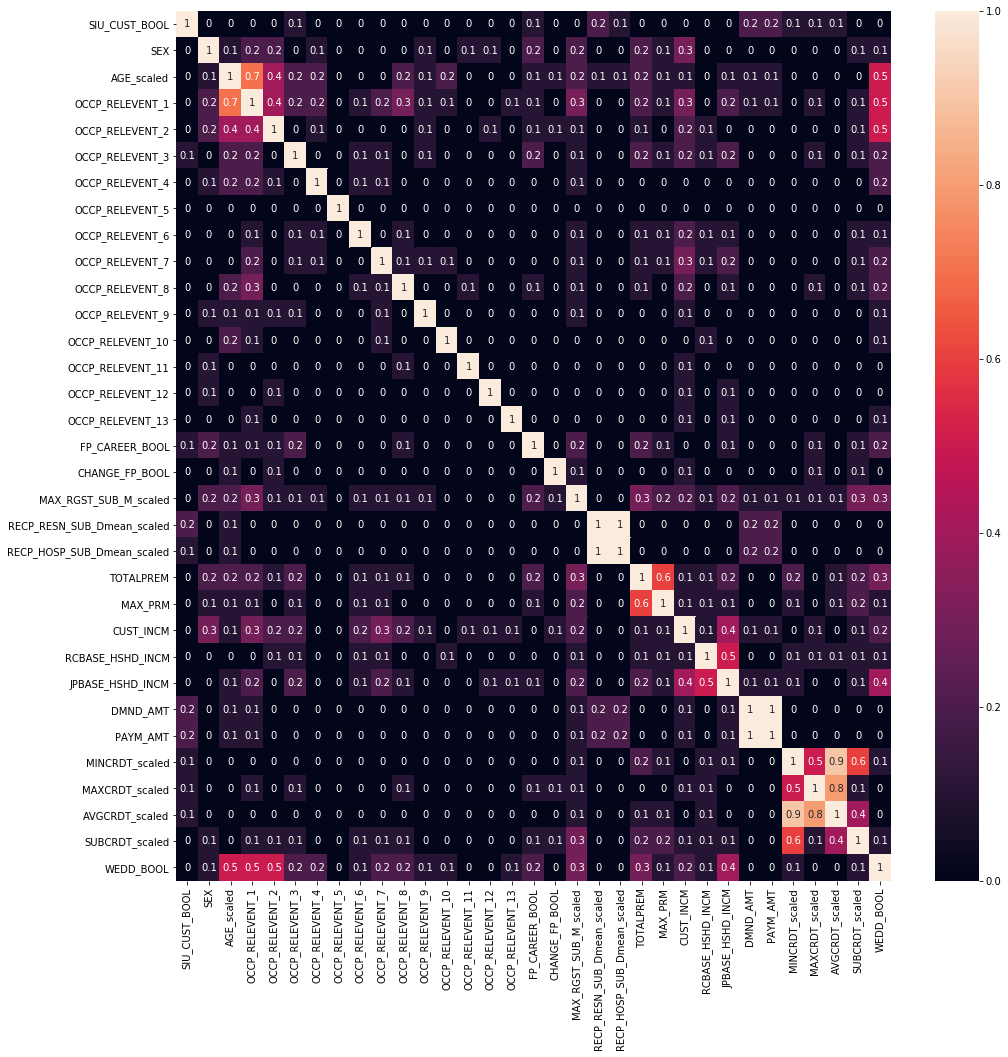

In [73]:
corrs = temp_df.corr()
corrs = corrs.apply(round, ndigits=1) # 소수 첫번째 자리까지
corrs = corrs.apply(abs) # 부호 보지 않음
plt.figure(figsize=(16, 16))
sns.heatmap(corrs, annot=True)

In [74]:
temp_df = temp_df.drop([
    "AGE_scaled", # 직업_학생(OCCP_RELEVENT_1)과 상관계수 너무 높음
    "RECP_RESN_SUB_Dmean_scaled", # 접수일자-퇴원일자(RECP_HOSP_SUB)와 상관계수 너무 높음
    "PAYM_AMT", # 청구금액(DMND_AMT)과 상관계수 너무 높음
    "MINCRDT_scaled", "MAXCRDT_scaled" # 평균 신용등급(AVGCRDT)과 상관계수 너무 높음
], axis=1)

cust_train_data = cust_train_data.drop([
    "AGE_scaled", "RECP_RESN_SUB_Dmean_scaled", "PAYM_AMT", "MINCRDT_scaled", "MAXCRDT_scaled"
], axis=1)
cust_test_data = cust_test_data.drop([
    "AGE_scaled", "RECP_RESN_SUB_Dmean_scaled", "PAYM_AMT", "MINCRDT_scaled", "MAXCRDT_scaled"
], axis=1)

In [75]:
temp_y = temp_df.iloc[:, 0]
temp_X = temp_df.iloc[:, 1:]

In [76]:
# 유의확률 확인
temp_X = sm.add_constant(temp_X)

reg = sm.OLS(temp_y, temp_X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SIU_CUST_BOOL   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     33.20
Date:                Tue, 25 Aug 2020   Prob (F-statistic):          5.98e-166
Time:                        22:08:08   Log-Likelihood:                -1811.3
No. Observations:               14424   AIC:                             3679.
Df Residuals:                   14396   BIC:                             3891.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0620      0.020     -3.028      0.002      -0.102      -0.022
SEX                           -0.0229      0.005     -4.269      0.000      -0.033      -0.012
OCCP_RELEVENT_1                0.0140      0.008      1.769      0.077      -0.002       0.029
OCCP_RELEVENT_2                0.0216      0.006      3.367      0.001       0.009       0.034
OCCP_RELEVENT_3                0.0358      0.007      5.117      0.000       0.022       0.050
OCCP_RELEVENT_4               -0.0062      0.009     -0.688      0.491      -0.024       0.012
OCCP_RELEVENT_5                0.0870      0.031      2.780      0.005       0.026       0.148
OCCP_RELEVENT_6               -0.0222      0.008     -2.707      0.007      -0.038      -0.006
OCCP_RELEVENT_7                0.0014      0.006      0.219      0.827      -0.011       0.014
OCCP_RELEVENT_8                0.0135      0.006      2.153      0.031       0.001       0.026
OCCP_RELEVENT_9               -0.0317      0.009     -3.497      0.000      -0.050      -0.014
OCCP_RELEVENT_10              -0.0375      0.014     -2.707      0.007      -0.065      -0.010
OCCP_RELEVENT_11              -0.0313      0.013     -2.423      0.015      -0.057      -0.006
OCCP_RELEVENT_12              -0.0366      0.015     -2.474      0.013      -0.066      -0.008
OCCP_RELEVENT_13              -0.0240      0.016     -1.475      0.140      -0.056       0.008
FP_CAREER_BOOL                 0.0351      0.010      3.377      0.001       0.015       0.055
CHANGE_FP_BOOL                 0.0244      0.005      5.213      0.000       0.015       0.034
MAX_RGST_SUB_M_scaled          0.0156      0.004      3.505      0.000       0.007       0.024
RECP_HOSP_SUB_Dmean_scaled     0.0774      0.007     11.507      0.000       0.064       0.091
TOTALPREM                  -1.434e-10   6.84e-11     -2.097      0.036   -2.77e-10   -9.36e-12
MAX_PRM                     8.592e-09    2.4e-09      3.583      0.000    3.89e-09    1.33e-08
CUST_INCM                   4.058e-06   1.43e-06      2.836      0.005    1.25e-06    6.86e-06
RCBASE_HSHD_INCM           -3.527e-06   8.81e-07     -4.002      0.000   -5.25e-06    -1.8e-06
JPBASE_HSHD_INCM            4.886e-07   1.12e-06      0.435      0.663   -1.71e-06    2.69e-06
DMND_AMT                    2.866e-09   1.66e-10     17.219      0.000    2.54e-09    3.19e-09
AVGCRDT_scaled                 0.2306      0.030      7.659      0.000       0.172       0.290
SUBCRDT_scaled                -0.0790      0.025     -3.099      0.002      -0.129      -0.029
WEDD_BOOL                      0.0008      0.007      0.106      0.915      -0.013       0.015
==============================================================================
Omnibus:                     7625.661   Durbin-Watson:     

In [77]:
vif_df = pd.DataFrame()
vif_df["feature"] = temp_X.columns
vif_df["VIF"] = [ vif(temp_X.values, i) for i in range(len(temp_X.columns)) ]

vif_df

,feature,VIF
0,const,80.215233
1,SEX,1.353643
2,OCCP_RELEVENT_1,2.110630
3,OCCP_RELEVENT_2,1.847533
4,OCCP_RELEVENT_3,1.402077
5,OCCP_RELEVENT_4,1.158659
6,OCCP_RELEVENT_5,1.020151
7,OCCP_RELEVENT_6,1.235292
8,OCCP_RELEVENT_7,1.382051
9,OCCP_RELEVENT_8,1.401984


In [78]:
temp_df = temp_df.drop([
    "OCCP_RELEVENT_4", # 직업_노무직및운전직: 유의확률 - 0.350
    "OCCP_RELEVENT_7", # 직업_사무직: 유의확률 - 0.924
    "OCCP_RELEVENT_13", # 직업_고위직: 유의확률 - 0.121
    "JPBASE_HSHD_INCM", # 가구소득추정금액2: 유의확률 - 0.562
    "WEDD_BOOL" # 결혼여부: 유의확률 - 0.922 (???)
], axis=1)

cust_train_data = cust_train_data.drop([
    "OCCP_RELEVENT_4", "OCCP_RELEVENT_7", "OCCP_RELEVENT_13", "JPBASE_HSHD_INCM", "WEDD_BOOL"
], axis=1)
cust_test_data = cust_test_data.drop([
    "OCCP_RELEVENT_4", "OCCP_RELEVENT_7", "OCCP_RELEVENT_13", "JPBASE_HSHD_INCM", "WEDD_BOOL"
], axis=1)

In [79]:
del temp_df, temp_X, temp_y

###### 개별 사건 데이터(2)

In [80]:
temp_df = doc_train_data.drop(["CUST_ID", "DSAS_LIST", "RESL_LIST"], axis=1)

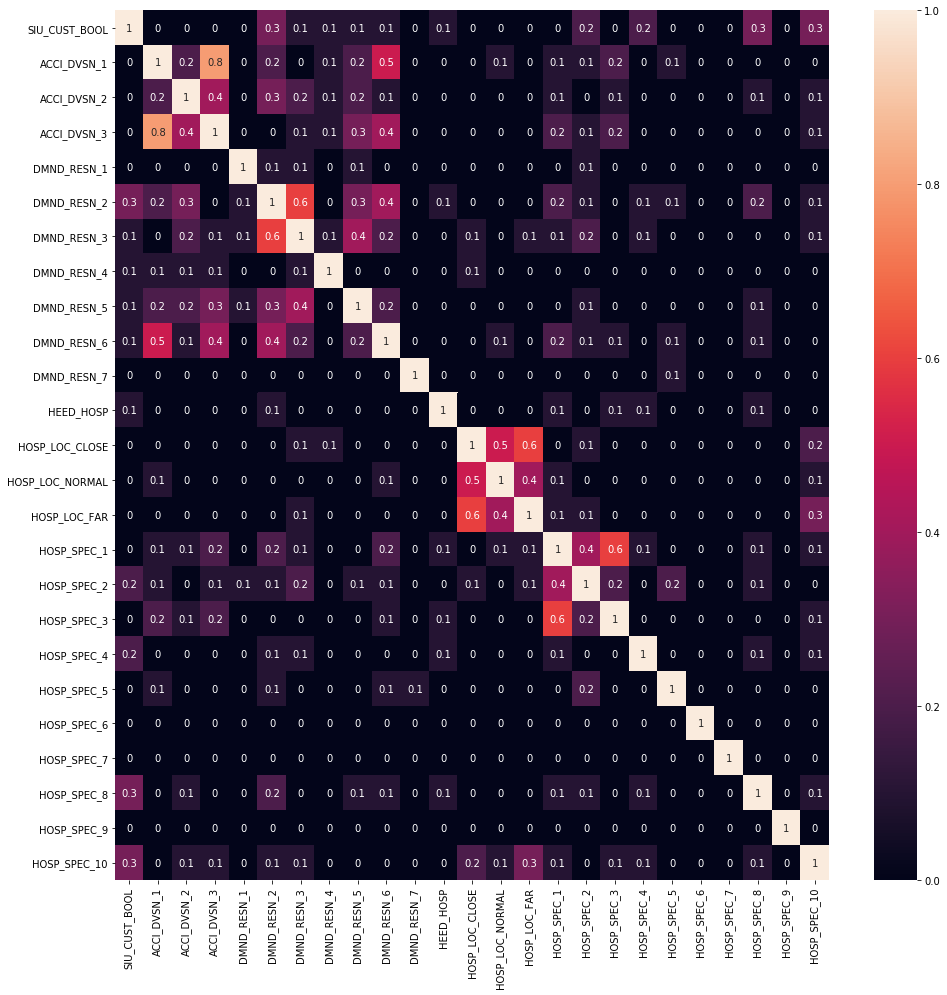

In [81]:
corrs = temp_df.corr()
corrs = corrs.apply(round, ndigits=1) # 소수 첫번째 자리까지
corrs = corrs.apply(abs) # 부호 보지 않음
plt.figure(figsize=(16, 16))
sns.heatmap(corrs, annot=True)

In [82]:
temp_y = temp_df.iloc[:, 0]
temp_X = temp_df.iloc[:, 1:]

In [83]:
# 유의확률 확인
temp_X = sm.add_constant(temp_X)

reg = sm.OLS(temp_y, temp_X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SIU_CUST_BOOL   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     197.6
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:08:12   Log-Likelihood:                -344.05
No. Observations:               14424   AIC:                             734.1
Df Residuals:                   14401   BIC:                             908.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.545e-15      0.175  -3.73e-14      1.000      -0.344       0.344
ACCI_DVSN_1         0.0161      0.073      0.221      0.825      -0.126       0.158
ACCI_DVSN_2        -0.0772      0.073     -1.061      0.289      -0.220       0.065
ACCI_DVSN_3        -0.0014      0.073     -0.020      0.984      -0.144       0.141
DMND_RESN_1        -0.0611      0.040     -1.517      0.129      -0.140       0.018
DMND_RESN_2         0.0811      0.034      2.421      0.016       0.015       0.147
DMND_RESN_3        -0.0975      0.034     -2.901      0.004      -0.163      -0.032
DMND_RESN_4         0.3484      0.053      6.538      0.000       0.244       0.453
DMND_RESN_5        -0.0989      0.034     -2.919      0.004      -0.165      -0.032
DMND_RESN_6        -0.1014      0.034     -2.958      0.003      -0.169      -0.034
DMND_RESN_7        -0.1333      0.082     -1.625      0.104      -0.294       0.027
HEED_HOSP           0.0208      0.003      8.129      0.000       0.016       0.026
HOSP_LOC_CLOSE     -0.0216      0.073     -0.298      0.766      -0.164       0.121
HOSP_LOC_NORMAL    -0.0108      0.073     -0.149      0.882      -0.153       0.132
HOSP_LOC_FAR       -0.0302      0.073     -0.416      0.677      -0.172       0.112
HOSP_SPEC_1         0.0498      0.007      7.581      0.000       0.037       0.063
HOSP_SPEC_2         0.0942      0.005     19.840      0.000       0.085       0.103
HOSP_SPEC_3        -0.0247      0.005     -4.792      0.000      -0.035      -0.015
HOSP_SPEC_4         0.2016      0.015     13.636      0.000       0.173       0.231
HOSP_SPEC_5         0.0118      0.010      1.152      0.249      -0.008       0.032
HOSP_SPEC_6         0.0842      0.062      1.357      0.175      -0.037       0.206
HOSP_SPEC_7         0.0625      0.048      1.307      0.191      -0.031       0.156
HOSP_SPEC_8         0.2126      0.008     25.115      0.000       0.196       0.229
HOSP_SPEC_9         0.0698      0.066      1.050      0.294      -0.061       0.200
HOSP_SPEC_10        0.1602      0.006     27.904      0.000       0.149       0.171
==============================================================================
Omnibus:                     6126.498   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26768.066
Skew:                           2.099   Prob(JB):                         0.00
Kurtosis:                       8.188   Cond. No.                     6.42e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.2e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [84]:
temp_df = temp_df.drop([
    "ACCI_DVSN_3", # 사고구분_질병: 다중공선성 우려
    "DMND_RESN_1", # 청구원인_사망: 다중공선성 우려
    "DMND_RESN_7", # 청구원인_치료: 다중공선성 우려
    "HOSP_LOC_NORMAL", # 병원거리_중간: 다중공선성 우려
    "HOSP_SPEC_5", # 병원종별구분_치과: 다중공선성 우려
    "HOSP_SPEC_6", # 병원종별구분_보건: 다중공선성 우려
    "HOSP_SPEC_7", # 병원종별구분_약국: 다중공선성 우려
    "HOSP_SPEC_9" # 병원종별구분_해외: 다중공선성 우려
], axis=1)

In [85]:
temp_y = temp_df.iloc[:, 0]
temp_X = temp_df.iloc[:, 1:]

# 유의확률 한번만 더 확인
temp_X = sm.add_constant(temp_X)

reg = sm.OLS(temp_y, temp_X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SIU_CUST_BOOL   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     271.3
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:08:12   Log-Likelihood:                -347.38
No. Observations:               14424   AIC:                             728.8
Df Residuals:                   14407   BIC:                             857.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0761      0.025     -2.985      0.003      -0.126      -0.026
ACCI_DVSN_1        0.0173      0.006      2.720      0.007       0.005       0.030
ACCI_DVSN_2       -0.0758      0.009     -8.465      0.000      -0.093      -0.058
DMND_RESN_2        0.1448      0.025      5.790      0.000       0.096       0.194
DMND_RESN_3       -0.0331      0.025     -1.310      0.190      -0.083       0.016
DMND_RESN_4        0.4117      0.054      7.672      0.000       0.307       0.517
DMND_RESN_5       -0.0343      0.025     -1.346      0.178      -0.084       0.016
DMND_RESN_6       -0.0362      0.027     -1.353      0.176      -0.089       0.016
HEED_HOSP          0.0209      0.003      8.166      0.000       0.016       0.026
HOSP_LOC_CLOSE    -0.0113      0.006     -1.844      0.065      -0.023       0.001
HOSP_LOC_FAR      -0.0193      0.007     -2.829      0.005      -0.033      -0.006
HOSP_SPEC_1        0.0499      0.007      7.619      0.000       0.037       0.063
HOSP_SPEC_2        0.0951      0.005     20.380      0.000       0.086       0.104
HOSP_SPEC_3       -0.0247      0.005     -4.792      0.000      -0.035      -0.015
HOSP_SPEC_4        0.2014      0.015     13.620      0.000       0.172       0.230
HOSP_SPEC_8        0.2127      0.008     25.130      0.000       0.196       0.229
HOSP_SPEC_10       0.1603      0.006     27.949      0.000       0.149       0.172
==============================================================================
Omnibus:                     6126.891   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26761.369
Skew:                           2.099   Prob(JB):                         0.00
Kurtosis:                       8.186   Cond. No.                         55.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
temp_df = temp_df.drop([
    "DMND_RESN_5", # 청구원인_수술: 다중공선성 우려
    "DMND_RESN_6" # 청구원인_진단: 다중공선성 우려
], axis=1)

In [87]:
temp_y = temp_df.iloc[:, 0]
temp_X = temp_df.iloc[:, 1:]

# 유의확률 딱 한번만 더 확인
temp_X = sm.add_constant(temp_X)

reg = sm.OLS(temp_y, temp_X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SIU_CUST_BOOL   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     310.0
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        22:08:12   Log-Likelihood:                -348.35
No. Observations:               14424   AIC:                             726.7
Df Residuals:                   14409   BIC:                             840.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1091      0.009    -12.385      0.000      -0.126      -0.092
ACCI_DVSN_1        0.0164      0.006      2.960      0.003       0.006       0.027
ACCI_DVSN_2       -0.0756      0.009     -8.589      0.000      -0.093      -0.058
DMND_RESN_2        0.1779      0.008     23.115      0.000       0.163       0.193
DMND_RESN_3        0.0004      0.007      0.049      0.961      -0.014       0.015
DMND_RESN_4        0.4452      0.048      9.283      0.000       0.351       0.539
HEED_HOSP          0.0209      0.003      8.158      0.000       0.016       0.026
HOSP_LOC_CLOSE    -0.0114      0.006     -1.860      0.063      -0.023       0.001
HOSP_LOC_FAR      -0.0192      0.007     -2.824      0.005      -0.033      -0.006
HOSP_SPEC_1        0.0499      0.007      7.651      0.000       0.037       0.063
HOSP_SPEC_2        0.0948      0.005     20.337      0.000       0.086       0.104
HOSP_SPEC_3       -0.0245      0.005     -4.782      0.000      -0.035      -0.014
HOSP_SPEC_4        0.2023      0.015     13.704      0.000       0.173       0.231
HOSP_SPEC_8        0.2128      0.008     25.149      0.000       0.196       0.229
HOSP_SPEC_10       0.1602      0.006     27.936      0.000       0.149       0.171
==============================================================================
Omnibus:                     6128.314   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26762.698
Skew:                           2.100   Prob(JB):                         0.00
Kurtosis:                       8.185   Cond. No.                         39.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
vif_df = pd.DataFrame()
vif_df["feature"] = temp_X.columns
vif_df["VIF"] = [ vif(temp_X.values, i) for i in range(len(temp_X.columns)) ]

vif_df

,feature,VIF
0,const,18.205050
1,ACCI_DVSN_1,1.124121
2,ACCI_DVSN_2,1.181790
3,DMND_RESN_2,1.764931
4,DMND_RESN_3,1.539523
5,DMND_RESN_4,1.030092
6,HEED_HOSP,1.035588
7,HOSP_LOC_CLOSE,1.659517
8,HOSP_LOC_FAR,1.765339
9,HOSP_SPEC_1,1.791510


In [89]:
temp_df = temp_df.drop([
    "DMND_RESN_3" # 청구원인_통원: 유의확률 - 0.961
], axis=1)

doc_train_data = doc_train_data.drop([
    "ACCI_DVSN_3", 
    "DMND_RESN_1", "DMND_RESN_3", "DMND_RESN_5", "DMND_RESN_6", "DMND_RESN_7", 
    "HOSP_LOC_NORMAL", 
    "HOSP_SPEC_5", "HOSP_SPEC_6", "HOSP_SPEC_7", "HOSP_SPEC_9"
], axis=1)
doc_test_data = doc_test_data.drop([
    "ACCI_DVSN_3", 
    "DMND_RESN_1", "DMND_RESN_3", "DMND_RESN_5", "DMND_RESN_6", "DMND_RESN_7", 
    "HOSP_LOC_NORMAL", 
    "HOSP_SPEC_5", "HOSP_SPEC_6", "HOSP_SPEC_7", "HOSP_SPEC_9"
], axis=1)

In [90]:
del temp_df, temp_X, temp_y, reg, vif_df

### 고객 개인 데이터(3)

In [91]:
cust_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CUST_ID,14424.0,1.115486e+04,6.446132e+03,1.0,5575.750000,1.112750e+04,1.672475e+04,2.240000e+04
SIU_CUST_BOOL,14424.0,8.763172e-02,2.827684e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
SEX,14424.0,4.318497e-01,4.953509e-01,0.0,0.000000,0.000000e+00,1.000000e+00,1.000000e+00
OCCP_RELEVENT_1,14424.0,2.306572e-01,4.212681e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
OCCP_RELEVENT_2,14424.0,3.787438e-01,4.850910e-01,0.0,0.000000,0.000000e+00,1.000000e+00,1.000000e+00
OCCP_RELEVENT_3,14424.0,1.828896e-01,3.865894e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
OCCP_RELEVENT_5,14424.0,5.476983e-03,7.380625e-02,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
OCCP_RELEVENT_6,14424.0,1.079451e-01,3.103218e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
OCCP_RELEVENT_8,14424.0,2.457016e-01,4.305173e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
OCCP_RELEVENT_9,14424.0,7.924293e-02,2.701269e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


###### TOTALPREM
- 고객이 지금까지 당사에 실제 납입한 총 보험료의 합계

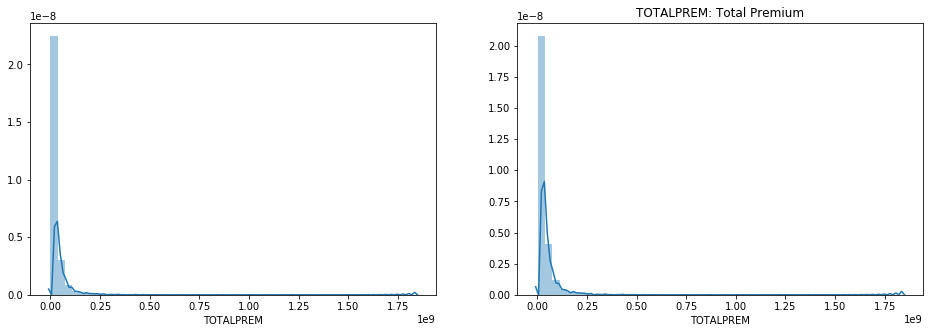

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(cust_train_data["TOTALPREM"], ax=axs[0])
plt.title("TOTALPREM: Total Premium")
sns.distplot(cust_train_data.loc[cust_train_data["TOTALPREM"] > 1000000, "TOTALPREM"], ax=axs[1])
plt.title("TOTALPREM: Total Premium")
plt.show()

In [93]:
cust_train_data["TOTALPREM"].median()

9235317.5

In [94]:
cust_train_data["TOTALPREM_scaled"] = \
    cust_train_data["TOTALPREM"]\
    .apply(lambda num_: (np.log(num_) / np.log(9000000))) # 중위값과 비슷한 값

In [95]:
cust_train_data["TOTALPREM_scaled"].describe()

count    14424.000000
mean         0.763855
std          0.455598
min          0.000000
25%          0.000000
50%          1.001612
75%          1.065897
max          1.332256
Name: TOTALPREM_scaled, dtype: float64

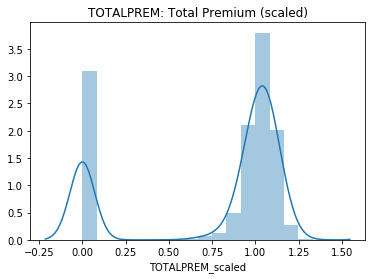

In [96]:
sns.distplot(cust_train_data["TOTALPREM_scaled"])
plt.title("TOTALPREM: Total Premium (scaled)")
plt.show()

In [97]:
# 평균적으로 신용등급 우수 - 1~2
totalprem_woosoo = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] < 0.25, "TOTALPREM_scaled"].mean()
# 평균적으로 신용등급 보통 - 3~5
totalprem_botong = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.25, 0.55), "TOTALPREM_scaled"].mean()
# 평균적으로 신용등급 보통 혹은 미확인 - 6
totalprem_unknown = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.55, 0.65), "TOTALPREM_scaled"].mean()
# 평균적으로 신용등급 주의 - 7~8
totalprem_zoouii = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.65, 0.85), "TOTALPREM_scaled"].mean()
# 평균적으로 신용등급 위험 - 9~10
totalprem_weehum = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] >= 0.85, "TOTALPREM_scaled"].mean()

print(totalprem_woosoo, 
      totalprem_botong, 
      totalprem_unknown, 
      totalprem_zoouii, 
      totalprem_weehum)

0.9116684889807979 0.9754351927150638 0.7257443123324143 0.9000858647223535 0.8482623339317591


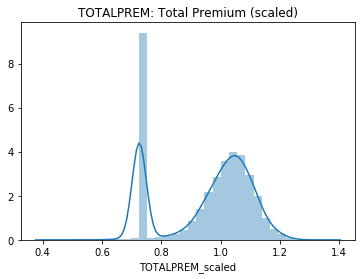

In [98]:
# 평균적으로 신용등급 6인 사람들의 TOTALPREM으로 fillna
cust_train_data.loc[
    cust_train_data["TOTALPREM_scaled"] == 0, "TOTALPREM_scaled"] = totalprem_unknown

sns.distplot(cust_train_data["TOTALPREM_scaled"])
plt.title("TOTALPREM: Total Premium (scaled)")
plt.show()

In [99]:
# 범위 조정
cust_train_data["TOTALPREM_scaled"] = cust_train_data["TOTALPREM_scaled"].apply(lambda num_: num_-1)

In [100]:
cust_test_data["TOTALPREM_scaled"] = \
    cust_test_data["TOTALPREM"]\
    .apply(lambda num_: (np.log(num_) / np.log(9000000))) # 중위값과 비슷한 값

cust_test_data.loc[
    cust_test_data["TOTALPREM_scaled"] == 0, "TOTALPREM_scaled"] = totalprem_unknown
cust_test_data["TOTALPREM_scaled"] = cust_test_data["TOTALPREM_scaled"].apply(lambda num_: num_-1)

cust_train_data = cust_train_data.drop("TOTALPREM", axis=1)
cust_test_data = cust_test_data.drop("TOTALPREM", axis=1)

In [101]:
del totalprem_woosoo, totalprem_botong, totalprem_unknown, totalprem_zoouii, totalprem_weehum

###### MAX_PRM
- 당사에 최대규모의 보험료를 납입했던 월보험료 수준

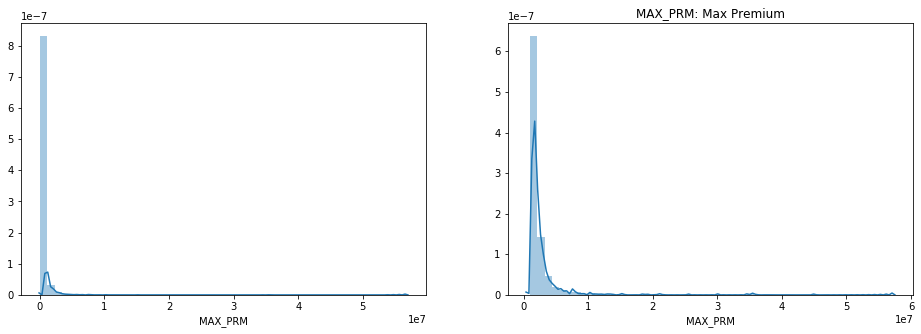

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(cust_train_data["MAX_PRM"], ax=axs[0])
plt.title("MAX_PRM: Max Premium")
sns.distplot(cust_train_data.loc[cust_train_data["MAX_PRM"] > 1000000, "MAX_PRM"], ax=axs[1])
plt.title("MAX_PRM: Max Premium")
plt.show()

In [103]:
cust_train_data["MAX_PRM"].median()

129933.0

In [104]:
cust_train_data["MAX_PRM_scaled"] = \
    cust_train_data["MAX_PRM"]\
    .apply(lambda num_: (np.log(num_) / np.log(100000))) # 중위값과 비슷한 값

In [105]:
cust_train_data["MAX_PRM_scaled"].describe()

count    14424.000000
mean         0.762243
std          0.493770
min          0.000000
25%          0.000000
50%          1.022744
75%          1.108921
max          1.550965
Name: MAX_PRM_scaled, dtype: float64

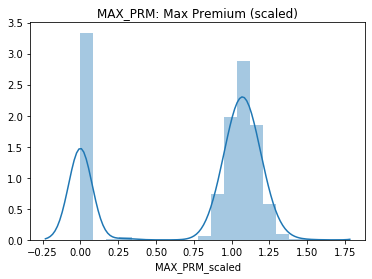

In [106]:
sns.distplot(cust_train_data["MAX_PRM_scaled"])
plt.title("MAX_PRM: Max Premium (scaled)")
plt.show()

In [107]:
# 평균적으로 신용등급 우수 - 1~2
maxprm_woosoo = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] < 0.25, "MAX_PRM_scaled"].mean()
# 평균적으로 신용등급 보통 - 3~5
maxprm_botong = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.25, 0.55), "MAX_PRM_scaled"].mean()
# 평균적으로 신용등급 보통 혹은 미확인 - 6
maxprm_unknown = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.55, 0.65), "MAX_PRM_scaled"].mean()
# 평균적으로 신용등급 주의 - 7~8
maxprm_zoouii = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.65, 0.85), "MAX_PRM_scaled"].mean()
# 평균적으로 신용등급 위험 - 9~10
maxprm_weehum = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] >= 0.85, "MAX_PRM_scaled"].mean()

print(maxprm_woosoo, 
      maxprm_botong, 
      maxprm_unknown, 
      maxprm_zoouii, 
      maxprm_weehum)

0.9003336348360922 1.0263728694649803 0.7119931080219309 0.9544687675235912 0.8958297559017253


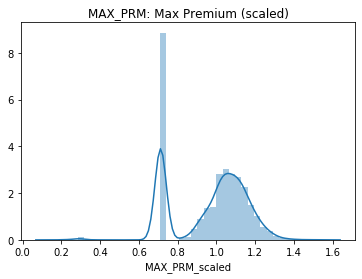

In [108]:
# 평균적으로 신용등급 6인 사람들의 TOTALPREM으로 fillna
cust_train_data.loc[
    cust_train_data["MAX_PRM_scaled"] == 0, "MAX_PRM_scaled"] = maxprm_unknown

sns.distplot(cust_train_data["MAX_PRM_scaled"])
plt.title("MAX_PRM: Max Premium (scaled)")
plt.show()

In [109]:
# 범위 조정
cust_train_data["MAX_PRM_scaled"] = cust_train_data["MAX_PRM_scaled"].apply(lambda num_: num_-1)

In [110]:
cust_test_data["MAX_PRM_scaled"] = \
    cust_test_data["MAX_PRM"]\
    .apply(lambda num_: (np.log(num_) / np.log(100000))) # 중위값과 비슷한 값

cust_test_data.loc[
    cust_test_data["MAX_PRM_scaled"] == 0, "MAX_PRM_scaled"] = maxprm_unknown
cust_test_data["MAX_PRM_scaled"] = cust_test_data["MAX_PRM_scaled"].apply(lambda num_: num_-1)

cust_train_data = cust_train_data.drop("MAX_PRM", axis=1)
cust_test_data = cust_test_data.drop("MAX_PRM", axis=1)

In [111]:
del maxprm_woosoo, maxprm_botong, maxprm_unknown, maxprm_zoouii, maxprm_weehum

###### CUST_INCM
- 고객의 연령/직업/보험료 수준등을 통한 고객의 개인 소득 추정금액

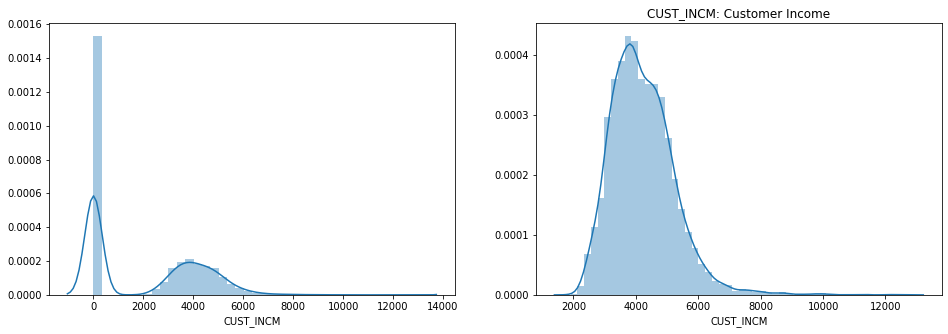

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(cust_train_data["CUST_INCM"], ax=axs[0])
plt.title("CUST_INCM: Customer Income")
sns.distplot(cust_train_data.loc[cust_train_data["CUST_INCM"] != 0, "CUST_INCM"], ax=axs[1])
plt.title("CUST_INCM: Customer Income")
plt.show()

In [113]:
cust_train_data["CUST_INCM"].median() # ???

0.0

In [114]:
cust_train_data.loc[cust_train_data["CUST_INCM"] != 0, "CUST_INCM"].median()

4104.0

In [115]:
cust_train_data.loc[cust_train_data["CUST_INCM"] < 1, "CUST_INCM"] = 1

cust_train_data["CUST_INCM_scaled"] = \
    cust_train_data["CUST_INCM"]\
    .apply(lambda num_: (np.log(num_) / np.log(4000))) # 중위값과 비슷한 값

In [116]:
cust_train_data["CUST_INCM_scaled"].describe()

count    14424.000000
mean         0.490948
std          0.502010
min          0.000000
25%          0.000000
50%          0.000000
75%          1.002358
max          1.139170
Name: CUST_INCM_scaled, dtype: float64

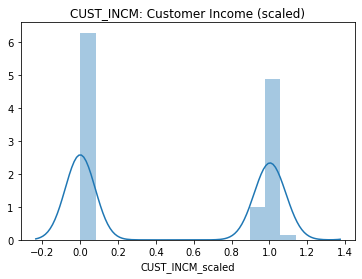

In [117]:
sns.distplot(cust_train_data["CUST_INCM_scaled"])
plt.title("CUST_INCM: Customer Income (scaled)")
plt.show() # ?????

In [118]:
# 평균적으로 신용등급 우수 - 1~2
custincm_woosoo = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] < 0.25, "CUST_INCM_scaled"].mean()
# 평균적으로 신용등급 보통 - 3~5
custincm_botong = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.25, 0.55), "CUST_INCM_scaled"].mean()
# 평균적으로 신용등급 보통 혹은 미확인 - 6
custincm_unknown = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.55, 0.65), "CUST_INCM_scaled"].mean()
# 평균적으로 신용등급 주의 - 7~8
custincm_zoouii = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.65, 0.85), "CUST_INCM_scaled"].mean()
# 평균적으로 신용등급 위험 - 9~10
custincm_weehum = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] >= 0.85, "CUST_INCM_scaled"].mean()

print(custincm_woosoo, 
      custincm_botong, 
      custincm_unknown, 
      custincm_zoouii, 
      custincm_weehum)

0.6281483843223247 0.6038298287629107 0.4572519758297111 0.6616883347253697 0.6382443707592306


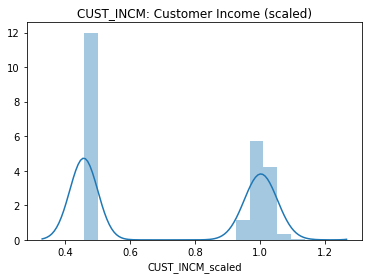

In [119]:
# 평균적으로 신용등급 6인 사람들의 TOTALPREM으로 fillna
cust_train_data.loc[
    cust_train_data["CUST_INCM_scaled"] == 0, "CUST_INCM_scaled"] = custincm_unknown

sns.distplot(cust_train_data["CUST_INCM_scaled"])
plt.title("CUST_INCM: Customer Income (scaled)")
plt.show()

In [120]:
cust_train_data["CUST_INCM_scaled"].describe()

count    14424.000000
mean         0.724488
std          0.273744
min          0.457252
25%          0.457252
50%          0.457252
75%          1.002358
max          1.139170
Name: CUST_INCM_scaled, dtype: float64

In [121]:
# 범위 조정
cust_train_data["CUST_INCM_scaled"] = cust_train_data["CUST_INCM_scaled"].apply(lambda num_: num_-0.4)

In [122]:
cust_test_data.loc[cust_test_data["CUST_INCM"] < 1, "CUST_INCM"] = 1

cust_test_data["CUST_INCM_scaled"] = \
    cust_test_data["CUST_INCM"]\
    .apply(lambda num_: (np.log(num_) / np.log(4000))) # 중위값과 비슷한 값

cust_test_data.loc[
    cust_test_data["CUST_INCM_scaled"] == 0, "CUST_INCM_scaled"] = custincm_unknown
cust_test_data["CUST_INCM_scaled"] = cust_test_data["CUST_INCM_scaled"].apply(lambda num_: num_-1)

cust_train_data = cust_train_data.drop("CUST_INCM", axis=1)
cust_test_data = cust_test_data.drop("CUST_INCM", axis=1)

In [123]:
del custincm_woosoo, custincm_botong, custincm_unknown, custincm_zoouii, custincm_weehum

###### RCBASE_HSHD_INCM
- 고객의 주택가격을 우선하여 정한 가구소득 추정금액

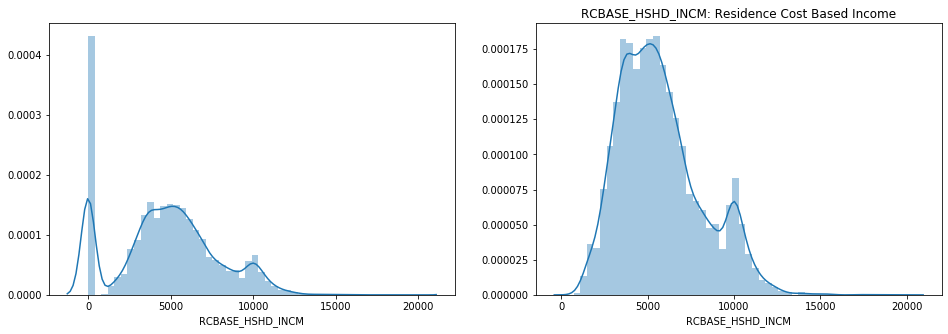

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(cust_train_data["RCBASE_HSHD_INCM"], ax=axs[0])
plt.title("RCBASE_HSHD_INCM: Residence Cost Based Income")
sns.distplot(cust_train_data.loc[cust_train_data["RCBASE_HSHD_INCM"] != 0, "RCBASE_HSHD_INCM"], ax=axs[1])
plt.title("RCBASE_HSHD_INCM: Residence Cost Based Income")
plt.show()

In [125]:
cust_train_data["RCBASE_HSHD_INCM"].median()

4799.0

In [126]:
cust_train_data.loc[cust_train_data["RCBASE_HSHD_INCM"] < 1, "RCBASE_HSHD_INCM"] = 1

cust_train_data["RCBASE_HSHD_INCM_scaled"] = \
    cust_train_data["RCBASE_HSHD_INCM"]\
    .apply(lambda num_: (np.log(num_) / np.log(5000))) # 중위값과 비슷한 값

In [127]:
cust_train_data["RCBASE_HSHD_INCM_scaled"].describe()

count    14424.000000
mean         0.833926
std          0.381472
min          0.000000
25%          0.938795
50%          0.995183
75%          1.032934
max          1.161756
Name: RCBASE_HSHD_INCM_scaled, dtype: float64

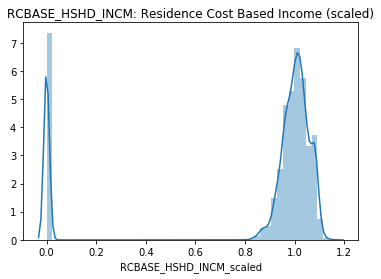

In [128]:
sns.distplot(cust_train_data["RCBASE_HSHD_INCM_scaled"])
plt.title("RCBASE_HSHD_INCM: Residence Cost Based Income (scaled)")
plt.show()

In [129]:
# 평균적으로 신용등급 우수 - 1~2
rcbase_woosoo = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] < 0.25, "RCBASE_HSHD_INCM_scaled"].mean()
# 평균적으로 신용등급 보통 - 3~5
rcbase_botong = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.25, 0.55), "RCBASE_HSHD_INCM_scaled"].mean()
# 평균적으로 신용등급 보통 혹은 미확인 - 6
rcbase_unknown = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.55, 0.65), "RCBASE_HSHD_INCM_scaled"].mean()
# 평균적으로 신용등급 주의 - 7~8
rcbase_zoouii = \
    cust_train_data.loc[
    cust_train_data["AVGCRDT_scaled"].between(0.65, 0.85), "RCBASE_HSHD_INCM_scaled"].mean()
# 평균적으로 신용등급 위험 - 9~10
rcbase_weehum = \
    cust_train_data.loc[cust_train_data["AVGCRDT_scaled"] >= 0.85, "RCBASE_HSHD_INCM_scaled"].mean()

print(rcbase_woosoo, 
      rcbase_botong, 
      rcbase_unknown, 
      rcbase_zoouii, 
      rcbase_weehum) # 신용등급으로 분리 X

0.9225392522051301 0.9081570356055612 0.8282543231400677 0.8184392650382378 0.8159901058897391


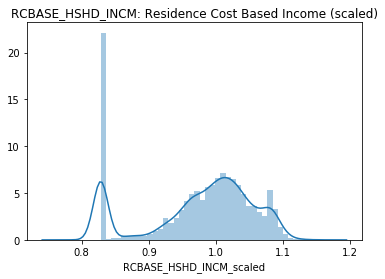

In [130]:
# 평균적으로 신용등급 6인 사람들의 TOTALPREM으로 fillna
cust_train_data.loc[
    cust_train_data["RCBASE_HSHD_INCM_scaled"] == 0, "RCBASE_HSHD_INCM_scaled"] = rcbase_unknown

sns.distplot(cust_train_data["RCBASE_HSHD_INCM_scaled"])
plt.title("RCBASE_HSHD_INCM: Residence Cost Based Income (scaled)")
plt.show()

In [131]:
cust_train_data["RCBASE_HSHD_INCM_scaled"].describe()

count    14424.000000
mean         0.975471
std          0.081455
min          0.773764
25%          0.938795
50%          0.995183
75%          1.032934
max          1.161756
Name: RCBASE_HSHD_INCM_scaled, dtype: float64

In [132]:
# 범위 조정
cust_train_data["RCBASE_HSHD_INCM_scaled"] = cust_train_data["RCBASE_HSHD_INCM_scaled"].apply(lambda num_: num_-0.2)

In [133]:
cust_test_data.loc[cust_test_data["RCBASE_HSHD_INCM"] < 1, "RCBASE_HSHD_INCM"] = 1

cust_test_data["RCBASE_HSHD_INCM_scaled"] = \
    cust_test_data["RCBASE_HSHD_INCM"]\
    .apply(lambda num_: (np.log(num_) / np.log(5000))) # 중위값과 비슷한 값

cust_test_data.loc[
    cust_test_data["RCBASE_HSHD_INCM_scaled"] == 0, "RCBASE_HSHD_INCM_scaled"] = rcbase_unknown
cust_test_data["RCBASE_HSHD_INCM_scaled"] = cust_test_data["RCBASE_HSHD_INCM_scaled"].apply(lambda num_: num_-1)

cust_train_data = cust_train_data.drop("RCBASE_HSHD_INCM", axis=1)
cust_test_data = cust_test_data.drop("RCBASE_HSHD_INCM", axis=1)

In [134]:
del rcbase_woosoo, rcbase_botong, rcbase_unknown, rcbase_zoouii, rcbase_weehum

###### DMND_AMT
- 사고보험금 청구금액

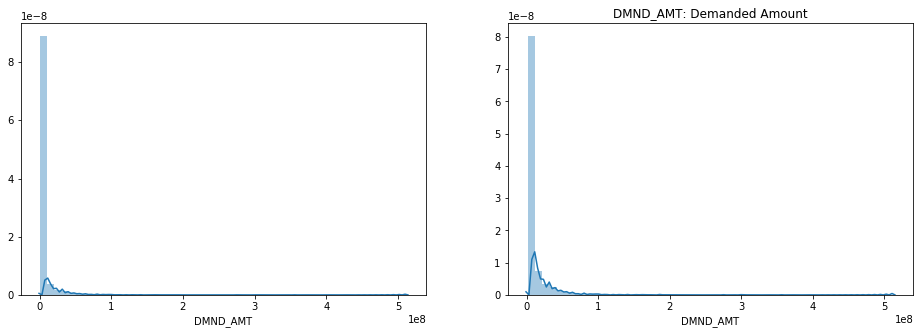

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(cust_train_data["DMND_AMT"], ax=axs[0])
plt.title("DMND_AMT: Demanded Amount")
sns.distplot(cust_train_data.loc[cust_train_data["DMND_AMT"] > 1000000, "DMND_AMT"], ax=axs[1])
plt.title("DMND_AMT: Demanded Amount")
plt.show()

In [136]:
cust_train_data["DMND_AMT"].median()

870000.0

In [137]:
cust_train_data.loc[cust_train_data["DMND_AMT"] < 1, "DMND_AMT"] = 1

cust_train_data["DMND_AMT_scaled"] = \
    cust_train_data["DMND_AMT"]\
    .apply(lambda num_: (np.log(num_) / np.log(900000))) # 중위값과 비슷한 값

In [138]:
cust_train_data["DMND_AMT_scaled"].describe()

count    14424.000000
mean         1.006735
std          0.117598
min          0.000000
25%          0.928998
50%          0.997527
75%          1.074809
max          1.462866
Name: DMND_AMT_scaled, dtype: float64

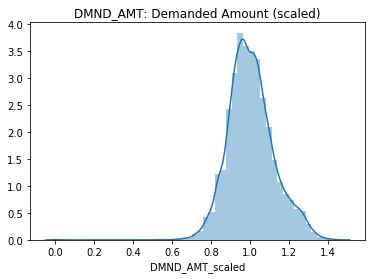

In [139]:
sns.distplot(cust_train_data["DMND_AMT_scaled"])
plt.title("DMND_AMT: Demanded Amount (scaled)")
plt.show()

In [140]:
# 범위 조정
cust_train_data["DMND_AMT_scaled"] = cust_train_data["DMND_AMT_scaled"].apply(lambda num_: num_-1)

In [141]:
cust_test_data.loc[cust_test_data["DMND_AMT"] < 1, "DMND_AMT"] = 1

cust_test_data["DMND_AMT_scaled"] = \
    cust_test_data["DMND_AMT"]\
    .apply(lambda num_: (np.log(num_) / np.log(900000))) # 중위값과 비슷한 값

cust_train_data.loc[cust_train_data["DMND_AMT"] < 1, "DMND_AMT"] = 1
cust_test_data["DMND_AMT_scaled"] = cust_test_data["DMND_AMT_scaled"].apply(lambda num_: num_-1)

cust_train_data = cust_train_data.drop("DMND_AMT", axis=1)
cust_test_data = cust_test_data.drop("DMND_AMT", axis=1)

###### 상관계수 다시 확인

In [142]:
temp_df = cust_train_data.drop(["CUST_ID"], axis=1)

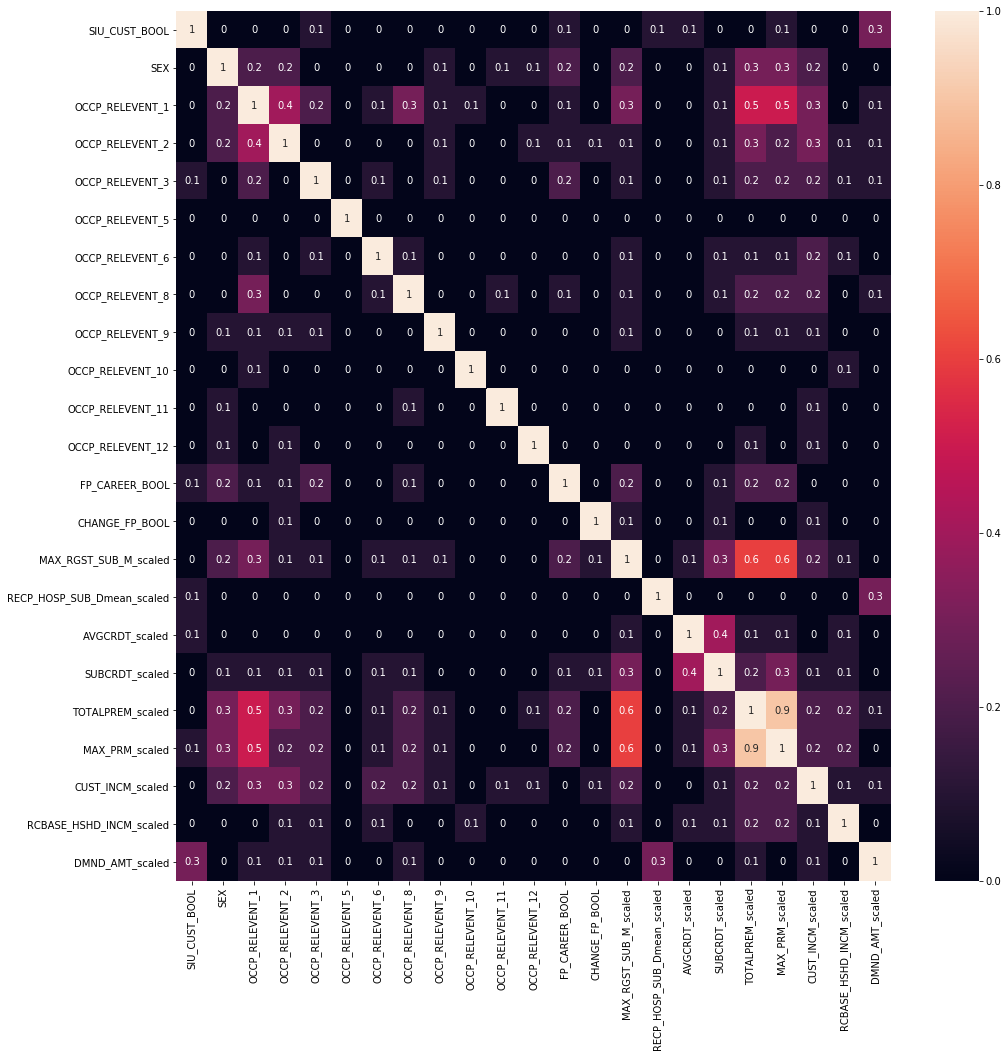

In [143]:
corrs = temp_df.corr()
corrs = corrs.apply(round, ndigits=1) # 소수 첫번째 자리까지
corrs = corrs.apply(abs) # 부호 보지 않음
plt.figure(figsize=(16, 16))
sns.heatmap(corrs, annot=True)

In [144]:
# TOTALPREM과 상관계수 높은 MAX_PRM 삭제
cust_train_data = cust_train_data.drop("MAX_PRM_scaled", axis=1)
cust_test_data = cust_test_data.drop("MAX_PRM_scaled", axis=1)

### 개별 사건 데이터(3)
* TFIDF 활용

In [145]:
doc_train_data.head()

,CUST_ID,SIU_CUST_BOOL,DSAS_LIST,RESL_LIST,ACCI_DVSN_1,ACCI_DVSN_2,DMND_RESN_2,DMND_RESN_4,HEED_HOSP,HOSP_LOC_CLOSE,HOSP_LOC_FAR,HOSP_SPEC_1,HOSP_SPEC_2,HOSP_SPEC_3,HOSP_SPEC_4,HOSP_SPEC_8,HOSP_SPEC_10
0,17766,1,"[족, 재건, 족관절염좌, 경추, 경추염좌, 양, 견, 급성, 벽, 양측견관절염좌,...","[부위, 상세불명부위, 경추, 발목, 탈구, 추, 상, 관절, 급성, 불명, 발, ...",0.916667,0.000000,0.583333,0.0,0.0,0.583333,0.416667,1.0,1.0,1.0,0.0,0.0,0.0
1,10914,0,"[요추염좌, 요추부수핵탈출증, 부수, 탈출증, 요추염좌외, 요추, 외, 핵, 염좌]","[관절, 허리뼈, 요추, 탈구, 인대, 골반, 긴장, 염좌]",1.000000,0.000000,0.222222,0.0,0.0,0.000000,1.000000,1.0,0.0,1.0,0.0,0.0,0.0
2,772,0,"[우측, 생물, 골절, 치루, 근본, 불명결장, 2, 절제술, 치루근본절제술, 불명...","[생물, 골절, 직장부의, 흉골, 항문, 양성, 부의, 흉추, 열구, 누공, 결장,...",0.333333,0.000000,0.000000,0.0,0.0,1.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0
3,20185,0,"[슬관절, 우측대퇴부좌상, 좌측, 우측, 상악, 경요추염좌, 제, 상악좌측제2, 치...","[부위, 신경, 경추, 탈구, 장애, 추, 관절, 치은염, 잇몸염, 염좌, 경, 안...",0.000000,0.333333,0.666667,0.0,0.0,0.666667,0.000000,1.0,1.0,0.0,0.0,1.0,0.0
4,10295,0,"[급성, 세균성, 복막, 급성충수염, 복막고름집, 장감염, 충수, 충수절제술, 절제...","[급성, 세균성, 기타, 장, 충수염, 감염]",0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.666667,0.0,1.0,0.0,0.0,0.0,0.0


In [146]:
temp_doc = doc_train_data["DSAS_LIST"] + doc_train_data["RESL_LIST"] 

In [147]:
def dummy_preprocessor(doc):
    doc_set = set(doc)
    if len(doc_set) == 0:
        return doc
    erase_set = set()
    for token in doc_set:
        if len(token) < 2:
            erase_set.add(token)
        elif re.search(r'\d', token):
            erase_set.add(token)
    return list(doc_set - erase_set)

temp_doc = temp_doc.apply(dummy_preprocessor)

del dummy_preprocessor

In [148]:
# AttributeError ('list' object has no attribute 'lower') 방지
dummy_tokenizer = lambda doc: doc
dummy_preprocessor = lambda doc: doc

MAX_FEATURES = 100
tfidf = TfidfVectorizer(max_features = MAX_FEATURES,
                        tokenizer=dummy_tokenizer,
                        preprocessor=dummy_preprocessor)

In [149]:
tfidfv = tfidf.fit(temp_doc)

C:\Programming\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [150]:
tfidf_sp_train = tfidfv.transform(doc_train_data["DSAS_LIST"] + doc_train_data["RESL_LIST"]).toarray()
tfidf_sp_test = tfidfv.transform(doc_test_data["DSAS_LIST"] + doc_test_data["RESL_LIST"]).toarray()

In [151]:
doc_train_data = doc_train_data.drop(["DSAS_LIST", "RESL_LIST"], axis=1)
doc_test_data = doc_test_data.drop(["DSAS_LIST", "RESL_LIST"], axis=1)

for i in range(0, MAX_FEATURES):
    newcol = "TFIDF_" + str(i)
    doc_train_data[newcol] = pd.Series(tfidf_sp_train[:, i])
    
for i in range(0, MAX_FEATURES):
    newcol = "TFIDF_" + str(i)
    doc_test_data[newcol] = pd.Series(tfidf_sp_test[:, i])

In [152]:
del temp_doc

In [153]:
tfidf.get_feature_names()

['간판',
 '감염',
 '거골',
 '결장',
 '결장염',
 '경부',
 '경추',
 '경하',
 '골반',
 '골절',
 '관의',
 '관절',
 '관절염',
 '근본',
 '근육',
 '급성',
 '기관지',
 '기관지염',
 '기타',
 '기타질환',
 '긴장',
 '뇌진탕',
 '늑골',
 '다리',
 '다발성',
 '단일',
 '동반',
 '두개골',
 '디스크',
 '만성',
 '목부위',
 '무릎',
 '발목',
 '발의',
 '발의골절',
 '병증',
 '부분',
 '부위',
 '불명',
 '상세불명',
 '상처',
 '생물',
 '손목',
 '손부위',
 '손상',
 '수술',
 '수지',
 '슬관절',
 '신경',
 '신경통',
 '아래',
 '아래다리',
 '아래팔',
 '악성',
 '안면',
 '안면골',
 '양성',
 '양측',
 '어깨',
 '염좌',
 '요골',
 '요추',
 '요추염좌',
 '요통',
 '우측',
 '위염',
 '위장염',
 '이상',
 '인대',
 '자궁',
 '장애',
 '절제술',
 '정복',
 '제거',
 '제외',
 '종골',
 '좌상',
 '좌측',
 '중족골',
 '증후군',
 '직장',
 '질환',
 '척골',
 '척추',
 '추간판',
 '추간판장애',
 '치핵',
 '타박상',
 '탈구',
 '탈출증',
 '통증',
 '파열',
 '폐쇄성',
 '포함',
 '항문',
 '허리',
 '허리뼈',
 '혈적',
 '흉골',
 '흉추']

# 학습 및 평가

### 학습

###### 데이터 정렬

In [154]:
cust_train_data.head()

,CUST_ID,SIU_CUST_BOOL,SEX,OCCP_RELEVENT_1,OCCP_RELEVENT_2,OCCP_RELEVENT_3,OCCP_RELEVENT_5,OCCP_RELEVENT_6,OCCP_RELEVENT_8,OCCP_RELEVENT_9,...,FP_CAREER_BOOL,CHANGE_FP_BOOL,MAX_RGST_SUB_M_scaled,RECP_HOSP_SUB_Dmean_scaled,AVGCRDT_scaled,SUBCRDT_scaled,TOTALPREM_scaled,CUST_INCM_scaled,RCBASE_HSHD_INCM_scaled,DMND_AMT_scaled
0,17766,1,0,0,0,1,0,0,0,0,...,0,1,0.193426,0.127999,0.55,0.1,-0.008827,0.576879,0.820916,0.150470
1,10914,0,0,0,0,0,0,1,0,0,...,0,1,0.068403,0.079581,0.60,0.0,0.073299,0.569811,0.860140,0.055207
2,772,0,1,0,1,0,0,1,0,0,...,0,1,-1.000000,-0.524732,0.60,0.0,-0.190904,0.627193,0.873592,0.050557
3,20185,0,0,0,0,1,0,0,1,0,...,1,0,0.421438,0.002027,0.45,0.3,0.218856,0.594449,0.767562,0.095209
4,10295,0,1,1,0,0,0,0,0,0,...,0,0,-1.000000,-0.875236,0.60,0.0,-0.274256,0.057252,0.716102,0.019776


In [155]:
doc_train_data.head()

,CUST_ID,SIU_CUST_BOOL,ACCI_DVSN_1,ACCI_DVSN_2,DMND_RESN_2,DMND_RESN_4,HEED_HOSP,HOSP_LOC_CLOSE,HOSP_LOC_FAR,HOSP_SPEC_1,...,TFIDF_90,TFIDF_91,TFIDF_92,TFIDF_93,TFIDF_94,TFIDF_95,TFIDF_96,TFIDF_97,TFIDF_98,TFIDF_99
0,17766,1,0.916667,0.000000,0.583333,0.0,0.0,0.583333,0.416667,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.159013,0.0,0.000000,0.198688
1,10914,0,1.000000,0.000000,0.222222,0.0,0.0,0.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.295598,0.0,0.000000,0.000000
2,772,0,0.333333,0.000000,0.000000,0.0,0.0,1.000000,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.235472,0.0,0.000000,0.0,0.236941,0.224681
3,20185,0,0.000000,0.333333,0.666667,0.0,0.0,0.666667,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,10295,0,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [156]:
final_train_data = pd.merge(
    cust_train_data,
    doc_train_data.drop("SIU_CUST_BOOL", axis=1),
    how="left",
    on="CUST_ID"
)

final_train_data = final_train_data.drop("CUST_ID", axis=1)

final_train_data.isna().sum().sum()

0

In [157]:
final_test_data = pd.merge(
    cust_test_data,
    doc_test_data.drop("SIU_CUST_BOOL", axis=1),
    how="left",
    on="CUST_ID"
)

final_test_data = final_test_data.drop("CUST_ID", axis=1)

final_test_data.isna().sum().sum()

0

In [158]:
CUST_LEN = len(cust_train_data.columns) - 2 # "CUST_ID", "SIU_CUST_BOOL"
DOC_LEN = len(doc_train_data.columns) - 2 # "CUST_ID", "SIU_CUST_BOOL"
CUST_LEN, DOC_LEN

(21, 113)

In [159]:
X_train, y_train = \
    final_train_data.iloc[:, 1:], final_train_data.iloc[:, 0]
X_test, y_test = \
    final_test_data.iloc[:, 1:], final_test_data.iloc[:, 0]

In [160]:
# SMOTE를 이용한 데이터 불균형 해결
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [161]:
X_train_smote, X_val_smote, y_train_smote, y_val_smote = \
    train_test_split(X_train_smote, y_train_smote, test_size=0.3, random_state=RANDOM_STATE)

In [162]:
Xcust_train, Xdoc_train = \
    X_train_smote.iloc[:, :CUST_LEN], X_train_smote.iloc[:, CUST_LEN:]
Xcust_val, Xdoc_val = \
    X_val_smote.iloc[:, :CUST_LEN], X_val_smote.iloc[:, CUST_LEN:]

del X_train_smote, X_val_smote

Xcust_test, Xdoc_test = \
    X_test.iloc[:, :CUST_LEN], X_test.iloc[:, CUST_LEN:]

In [163]:
Xcust_train.head()

,SEX,OCCP_RELEVENT_1,OCCP_RELEVENT_2,OCCP_RELEVENT_3,OCCP_RELEVENT_5,OCCP_RELEVENT_6,OCCP_RELEVENT_8,OCCP_RELEVENT_9,OCCP_RELEVENT_10,OCCP_RELEVENT_11,...,FP_CAREER_BOOL,CHANGE_FP_BOOL,MAX_RGST_SUB_M_scaled,RECP_HOSP_SUB_Dmean_scaled,AVGCRDT_scaled,SUBCRDT_scaled,TOTALPREM_scaled,CUST_INCM_scaled,RCBASE_HSHD_INCM_scaled,DMND_AMT_scaled
16797,0,0,1,0,0,0,0,0,0,0,...,0,0,-1.000000,-0.447529,0.60,0.0,-0.080807,0.057252,0.829659,0.009484
8458,1,0,0,0,0,0,0,1,0,0,...,0,1,0.189523,-0.084224,0.50,0.2,0.026195,0.601468,0.783108,-0.247089
12830,1,1,0,0,0,0,0,0,0,0,...,0,1,-1.000000,0.415873,0.60,0.0,-0.274256,0.576036,0.842568,-0.155058
3773,0,0,1,0,0,0,1,0,0,0,...,0,0,-0.500000,-0.215786,0.60,0.0,0.100827,0.057252,0.810848,0.204719
817,0,0,1,0,0,0,1,0,0,0,...,0,1,0.261829,-0.492119,0.65,0.1,0.010710,0.057252,0.806353,-0.024867


In [164]:
Xdoc_train.head()

,ACCI_DVSN_1,ACCI_DVSN_2,DMND_RESN_2,DMND_RESN_4,HEED_HOSP,HOSP_LOC_CLOSE,HOSP_LOC_FAR,HOSP_SPEC_1,HOSP_SPEC_2,HOSP_SPEC_3,...,TFIDF_90,TFIDF_91,TFIDF_92,TFIDF_93,TFIDF_94,TFIDF_95,TFIDF_96,TFIDF_97,TFIDF_98,TFIDF_99
16797,0.317411,0.22753,0.613765,0.0,0.0,0.613765,0.0,1.0,0.317411,1.0,...,0.0,0.0,0.0,0.293946,0.0,0.0,0.088542,0.0,0.0,0.0
8458,0.000000,0.00000,0.000000,0.0,0.0,1.000000,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
12830,0.000000,0.00000,0.666667,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3773,0.000000,0.00000,0.400000,0.0,0.0,1.000000,0.0,1.0,0.000000,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
817,0.000000,0.00000,0.500000,0.0,0.0,0.500000,0.0,1.0,1.000000,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


###### 모델 준비
* Multimodal Fully Connected DNN
  * 고객 개인정보 (성별, 직업, 보험료 등)
  * 고객 별 접수한 사건들에 대한 병명/결과내용 텍스트 데이터와 사고원인, 청구사유, 병원종류 데이터

In [165]:
print(CUST_LEN)
cust_inputs = Input(shape=(len(Xcust_train.columns),))
cust = Dense(32, activation="relu")(cust_inputs)    # hidden1
cust = Dense(32, activation="relu")(cust)           # hidden2
cust = Dense(32, activation="relu")(cust)           # hidden3
cust_model = Model(inputs=cust_inputs, outputs=cust)

21
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [166]:
print(DOC_LEN)
doc_inputs = Input(shape=(len(Xdoc_train.columns),))
doc = Dense(128, activation="relu")(doc_inputs)     # hidden1
doc = Dense(64, activation="relu")(doc)             # hidden2
doc = Dense(32, activation="relu")(doc)             # hidden3
doc_model = Model(inputs=doc_inputs, outputs=doc)

113


In [167]:
mid_result = concatenate([cust_model.output, doc_model.output])
concat_ = Dense(32, activation="relu")(mid_result)  # hidden4
concat_ = Dense(32, activation="relu")(concat_)     # hidden5
output = Dense(1, activation="sigmoid")(concat_)

model = Model(inputs=[cust_model.input, doc_model.input], outputs=output)

In [168]:
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])
model.optimizer.lr = 0.001

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


###### 모델 학습

In [169]:
t0 = time.time()

In [170]:
history = model.fit(x=[Xcust_train, Xdoc_train], y=y_train_smote, 
                    validation_data=([Xcust_val, Xdoc_val], y_val_smote),
                    epochs=30, verbose=2)

Train on 18424 samples, validate on 7896 samples
Epoch 1/30
18424/18424 - 2s - loss: 0.6885 - acc: 0.5543 - val_loss: 0.6871 - val_acc: 0.5769
Epoch 2/30
18424/18424 - 1s - loss: 0.6859 - acc: 0.5959 - val_loss: 0.6844 - val_acc: 0.6211
Epoch 3/30
18424/18424 - 1s - loss: 0.6832 - acc: 0.6282 - val_loss: 0.6815 - val_acc: 0.6388
Epoch 4/30
18424/18424 - 1s - loss: 0.6801 - acc: 0.6476 - val_loss: 0.6781 - val_acc: 0.6513
Epoch 5/30
18424/18424 - 1s - loss: 0.6765 - acc: 0.6590 - val_loss: 0.6740 - val_acc: 0.6651
Epoch 6/30
18424/18424 - 1s - loss: 0.6719 - acc: 0.6722 - val_loss: 0.6688 - val_acc: 0.6769
Epoch 7/30
18424/18424 - 1s - loss: 0.6659 - acc: 0.6848 - val_loss: 0.6619 - val_acc: 0.6914
Epoch 8/30
18424/18424 - 1s - loss: 0.6578 - acc: 0.7009 - val_loss: 0.6523 - val_acc: 0.7074
Epoch 9/30
18424/18424 - 1s - loss: 0.6464 - acc: 0.7187 - val_loss: 0.6390 - val_acc: 0.7304
Epoch 10/30
18424/18424 - 1s - loss: 0.6304 - acc: 0.7440 - val_loss: 0.6203 - val_acc: 0.7575
Epoch 11/3

In [171]:
print(f"Fit took {datetime.timedelta(seconds=int(round(time.time() - t0)))} seconds.")

Fit took 0:00:36 seconds.


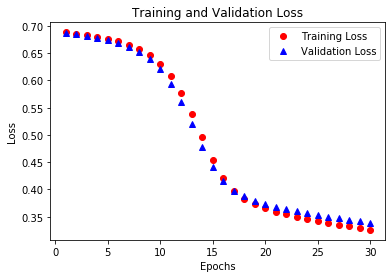

In [172]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "ro", label="Training Loss")
plt.plot(epochs, val_loss, "b^", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

### 평가

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      5641
           1       0.37      0.74      0.49       542

    accuracy                           0.87      6183
   macro avg       0.67      0.81      0.71      6183
weighted avg       0.92      0.87      0.89      6183

FINAL RESULT
6183/6183 [==============================] - 0s 26us/sample - loss: 0.3211 - acc: 0.8666
	score:	[0.3211487451601082, 0.86656964]
	total f1_score:	0.4941753525444512


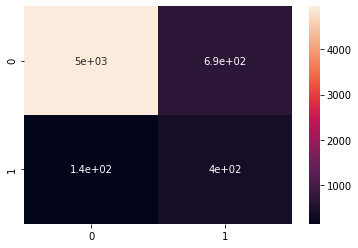

In [173]:
y_pred = model.predict([Xcust_test, Xdoc_test])
y_pred = y_pred.round().astype("int8")

print(classification_report(y_test, y_pred))
print("FINAL RESULT")
print(f"\tscore:\t{model.evaluate([Xcust_test, Xdoc_test], y_test)}")
print(f"\ttotal f1_score:\t{f1_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()